# IA for HumanForYou - Groupe 1

## Projet : Intelligence Artificielle

## Membres
|Auteur|
|---|
|_Youssef RAIES_|CESI Nanterre|2024/03|
|_Milan SANGARE_|
|_Jibril LAMRAOUI_|
|_Killian DEBRAIZE_|
|_Alexandre DE JESUS CORREIA_|

## Contexte
L'entreprise de produits pharmaceutiques "HumanForYou", basée en Inde, emploie environ 4000 personnes. Cependant, chaque année, elle subit un 'turn-over' (c'est-à-dire le taux de renouvellement du personnel dans l'entreprise) d'environ 15% de ses employés nécessitant de retrouver des profils similaires sur le marché de l'emploi.

La direction trouve que ce niveau de 'turn-over' n'est pas bon pour l'entreprise car :
- Les projets sur lesquels étaient les employés quittant la société prennent du retard, ce qui nuit à la réputation de l'entreprise auprès de ses clients et partenaires.
- Un service de ressources humaines de taille conséquente doit être conservé, car il faut avoir les moyens de trouver les nouvelles recrues.
- Du temps est perdu à l'arrivée des nouveaux employés, car ils doivent très souvent être formés et ont besoin de temps pour devenir pleinement opérationnels dans leur nouvel environnement.

## Données fournies


Nous disposons de différents datasets (au format CSV), sur un certain nombre de données (anonymisées) concernant les employés :
- **general_data** : les données du service des ressources humaines (âge, genre, niveau d'étude, ...)
- **manager_survey_data** : la dernière évaluation de chaque employé faite pas son manager en février 2015 
- **employee_survey_data** : enquête soumise aux employés en juin 2015 par le service RH pour avoir un retour concernant leur qualité de vie au travail
- **in_time** : horaires d'entrée des employés à leur poste, par date sur une période allant du 1er janvier au 31 décembre 2015
- **out_time** : horaires de sortie des employés à leur poste, par date sur une période allant du 1er janvier au 31 décembre 2015


## Objectif

Nous cherchons à déterminer les facteurs ayant le plus d'influence sur le taux de 'turn-over' et proposer des modèles afin d'avoir des pistes d'amélioration pour donner aux employés l'envie de rester.
Notre variable 'cible' (ou variable 'target') sera la variable `"Attrition"`, correspondant à si l'employé a quitté l'entreprise durant l'année 2016.


### Initialisation du notebook avec toutes les librairies et les constantes

In [1]:
import numpy as np
import os
import pandas as pd
import sklearn
from datetime import datetime
import math
from numpy.random import default_rng

random=default_rng(42)
np.random.seed(42)
RANDOM_SEED = 42
BOLD = '\033[1m'
END = '\033[0m'
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "workflowDS"


c:\Users\lamra\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Importation des données

In [2]:
# Importation des données
HR_Data = pd.read_csv("general_data.csv")
employeeSurveyData = pd.read_csv("employee_survey_data.csv")
managerSurveyData = pd.read_csv("manager_survey_data.csv")
dfIn = pd.read_csv('in_time.csv')
dfOut = pd.read_csv('out_time.csv')

### Merge des différentes sources de données

In [3]:
# Merger les données

dataset = pd.merge(HR_Data, employeeSurveyData,on = ['EmployeeID'] , how='inner')
dataset = pd.merge(dataset, managerSurveyData ,on = ['EmployeeID'] , how='inner')

In [4]:
# adaptation des donnees Date/Heure

publicHoliday = ['2015-01-01','2015-01-14','2015-01-26','2015-03-05','2015-05-01','17-07-2015','17-09-2015','2015-10-02','09-11-2015','2015-11-10', '2015-11-11','2015-12-25']


for idx, row in dfIn.iterrows():
    absenceCount = 0
    presenceCount = 0
    respectFullHours = 0
    totalWorkedHours = 0
    totalWorkedAdditionalHours = 0
    doAdditionnalHours = 0

    for r in row.index:

        if not isinstance(dfIn.at[idx, r], str):
            if math.isnan(dfIn.at[idx, r]) and r not in publicHoliday:
                absenceCount += 1
            continue
        else:
            presenceCount += 1

        inTimeVal = dfIn.at[idx, r]
        outTime = dfOut.at[idx, r]

        t1 = datetime.strptime(inTimeVal, "%Y-%m-%d %H:%M:%S")
        t2 = datetime.strptime(outTime, "%Y-%m-%d %H:%M:%S")

        diff = (t2 - t1).total_seconds() / 3600

        if diff > 8:
            respectFullHours += 1

        totalWorkedHours += diff
        totalWorkedAdditionalHours += diff - 8
    if totalWorkedAdditionalHours < 0:
        totalWorkedAdditionalHours = 0
    if totalWorkedAdditionalHours > 0:
        doAdditionnalHours = 1

    daysSupposedToBeWorked = absenceCount + presenceCount
    dataset.at[idx, 'AbsenceCount'] = absenceCount
    dataset.at[idx, 'PresenceCount'] = presenceCount
    dataset.at[idx, 'DaysSupposedToBeWorked'] = daysSupposedToBeWorked
    dataset.at[idx, 'RespectFullHours'] = respectFullHours # > 8
    dataset.at[idx, 'NotRespectFullHours'] = presenceCount - respectFullHours # < 8
    dataset.at[idx, 'TotalWorkedHours'] = totalWorkedHours
    dataset.at[idx, 'TotalWorkedAdditionalHours'] = totalWorkedAdditionalHours
    dataset.at[idx, 'WorkingAdditionalHoursAverage'] = totalWorkedAdditionalHours / daysSupposedToBeWorked # TotalWorkedAdditionalHours / PresenceCount
    dataset.at[idx, 'doAdditionnalHours'] = doAdditionnalHours # TotalWorkedAdditionalHours / PresenceCount
    dataset.at[idx, 'WorkingHoursAverage'] = totalWorkedHours / daysSupposedToBeWorked # TotalWorkedHours / PresenceCount
    dataset.at[idx, 'PresencePercentage'] = (presenceCount / daysSupposedToBeWorked) * 100  # (PresenceCount / TotalCount) * 100

### Visualisation de notre jeu de données

In [5]:
dataset.head(100)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,PresenceCount,DaysSupposedToBeWorked,RespectFullHours,NotRespectFullHours,TotalWorkedHours,TotalWorkedAdditionalHours,WorkingAdditionalHoursAverage,doAdditionnalHours,WorkingHoursAverage,PresencePercentage
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,232.0,252.0,0.0,232.0,1710.686944,0.000000,0.000000,0.0,6.788440,92.063492
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,236.0,252.0,42.0,194.0,1821.676667,0.000000,0.000000,0.0,7.228876,93.650794
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,242.0,252.0,0.0,242.0,1697.204167,0.000000,0.000000,0.0,6.734937,96.031746
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,235.0,252.0,0.0,235.0,1690.514444,0.000000,0.000000,0.0,6.708391,93.253968
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,245.0,252.0,115.0,130.0,1961.512778,1.512778,0.006003,1.0,7.783781,97.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,37,No,Travel_Rarely,Research & Development,8,5,Technical Degree,1,96,Male,...,247.0,252.0,247.0,0.0,2667.170833,691.170833,2.742741,1.0,10.584011,98.015873
96,30,No,Non-Travel,Sales,25,4,Other,1,97,Male,...,245.0,252.0,245.0,0.0,2548.334167,588.334167,2.334659,1.0,10.112437,97.222222
97,26,No,Travel_Rarely,Sales,28,3,Medical,1,98,Female,...,243.0,252.0,0.0,243.0,1456.621389,0.000000,0.000000,0.0,5.780244,96.428571
98,42,No,Travel_Rarely,Sales,2,2,Medical,1,99,Female,...,239.0,252.0,0.0,239.0,1461.033333,0.000000,0.000000,0.0,5.797751,94.841270


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            4410 non-null   int64  
 1   Attrition                      4410 non-null   object 
 2   BusinessTravel                 4410 non-null   object 
 3   Department                     4410 non-null   object 
 4   DistanceFromHome               4410 non-null   int64  
 5   Education                      4410 non-null   int64  
 6   EducationField                 4410 non-null   object 
 7   EmployeeCount                  4410 non-null   int64  
 8   EmployeeID                     4410 non-null   int64  
 9   Gender                         4410 non-null   object 
 10  JobLevel                       4410 non-null   int64  
 11  JobRole                        4410 non-null   object 
 12  MaritalStatus                  4410 non-null   o

In [7]:
dataset.describe()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,PresenceCount,DaysSupposedToBeWorked,RespectFullHours,NotRespectFullHours,TotalWorkedHours,TotalWorkedAdditionalHours,WorkingAdditionalHoursAverage,doAdditionnalHours,WorkingHoursAverage,PresencePercentage
count,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4410.0,...,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.00000,4410.000000,4410.000000
mean,36.923810,9.192517,2.912925,1.0,2205.500000,2.063946,65029.312925,2.694830,15.209524,8.0,...,236.265306,252.0,76.153061,160.112245,1821.276283,102.101459,0.405165,0.30000,7.227287,93.756074
std,9.133301,8.105026,1.023933,0.0,1273.201673,1.106689,47068.888559,2.498887,3.659108,0.0,...,5.503779,0.0,100.020061,98.799440,331.361528,198.871768,0.789174,0.45831,1.314927,2.184039
min,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,...,225.000000,252.0,0.000000,0.000000,1348.803056,0.000000,0.000000,0.00000,5.352393,89.285714
25%,30.000000,2.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,8.0,...,232.000000,252.0,0.000000,29.000000,1563.572500,0.000000,0.000000,0.00000,6.204653,92.063492
50%,36.000000,7.000000,3.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,8.0,...,236.000000,252.0,6.000000,226.000000,1745.782222,0.000000,0.000000,0.00000,6.927707,93.650794
75%,43.000000,14.000000,4.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,8.0,...,241.000000,252.0,205.000000,235.000000,1967.295347,86.960903,0.345083,1.00000,7.806728,95.634921
max,60.000000,29.000000,5.000000,1.0,4410.000000,5.000000,199990.000000,9.000000,25.000000,8.0,...,248.000000,252.0,248.000000,246.000000,2723.378056,747.378056,2.965786,1.00000,10.807056,98.412698


### Affichage des valeurs/pourcentages manquantes ou vides pour chaque DataFrame (Head)

In [8]:
def check_df(df, name):

    nan_values = df.isna().sum().sum()
    empty_values = df.iloc[:, :].eq('').sum(axis=1).sum()
    total_values = df.count().sum()

    print(f"Dataframe: {name} ")
    print(f"There's {BOLD}{nan_values} ({nan_values * 100 / total_values:.1f}%){END} NaN field(s) and {BOLD}{empty_values} ({empty_values * 100 / total_values:.1f}%){END} empty field(s) out of {BOLD}{total_values}{END} field(s)")
    print(f"The shape of the dataset is {df.shape}\n")

### general_data

In [9]:
check_df(HR_Data, "general_data")
HR_Data.head(2)

Dataframe: general_data 
There's 28 (0.0%) NaN field(s) and 0 (0.0%) empty field(s) out of 105812 field(s)
The shape of the dataset is (4410, 24)



,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4


### Manager_Survey_Data

In [10]:
check_df(managerSurveyData, "manager_srv_df")
managerSurveyData.head(2)

Dataframe: manager_srv_df 
There's 0 (0.0%) NaN field(s) and 0 (0.0%) empty field(s) out of 13230 field(s)
The shape of the dataset is (4410, 3)



,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4


### Employee_Survey_Data

In [11]:
check_df(employeeSurveyData, "employee_srv_df")
employeeSurveyData.head(2)

Dataframe: employee_srv_df 
There's 83 (0.5%) NaN field(s) and 0 (0.0%) empty field(s) out of 17557 field(s)
The shape of the dataset is (4410, 4)



,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0


### In_Time_data

In [12]:
check_df(dfIn, "in_time_df")
dfIn.head(2)

Dataframe: in_time_df 
There's 109080 (10.4%) NaN field(s) and 0 (0.0%) empty field(s) out of 1046340 field(s)
The shape of the dataset is (4410, 262)



,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20


### Out_Time_data

In [13]:
check_df(dfOut, "out_time_df")
dfOut.head(2)

Dataframe: out_time_df 
There's 109080 (10.4%) NaN field(s) and 0 (0.0%) empty field(s) out of 1046340 field(s)
The shape of the dataset is (4410, 262)



,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58


**Conclusion**:
On remarque également un grand nombre de 'features': il serait utile de les réduire avant de joindre ce dataset aux autres. 
De plus, on remarque aussi la présence de valeurs "NaN", cela doit correspondre aux jours où l'employé n'a pas badgé, et a donc été absent.

### Conclusion de l'Analyse visuelle des données
Au global, les données semblent bonnes. Nous allons rassembler les différents datasets sur l'*EmployeeID*, il sera ainsi facile de diviser le dataframe en deux (sets d'entraînement et de test).
Toutefois, il est nécessaire de renommer la première colonne de 'in_time_df' et 'out_time_df', qui ne sont pas nommées mais correspondent à l'*EmployeeID*. Les dataframes 'in_time' et 'out_time' sont importants (262 colonnes chacun), nous allons donc effectuer un traitement avant de les joindre au dataframe principal.


### Refactorisation de in_time et out_time pour l'étude
#### EmployeeID

In [14]:
def rename_first_col(df, name):
    arr = df.columns.tolist()
    arr[0] = name
    df.columns = arr
    return df

final_time_df = pd.DataFrame()
final_time_df["EmployeeID"] = HR_Data["EmployeeID"]

dfOut = rename_first_col(dfOut, 'EmployeeID')
dfIn = rename_first_col(dfIn, 'EmployeeID')

#### Vérification des données (shape, structure, intégrité)
Nous allons rapidement vérifier la structure globale, l'intégrité, et les types de notre dataframe.

In [15]:
check_df(dfOut, "Out Time")
check_df(dfIn, "In Time")
print("\n\n", dfOut.info())
dfOut.head(3)

Dataframe: Out Time 
There's 109080 (10.4%) NaN field(s) and 0 (0.0%) empty field(s) out of 1046340 field(s)
The shape of the dataset is (4410, 262)

Dataframe: In Time 
There's 109080 (10.4%) NaN field(s) and 0 (0.0%) empty field(s) out of 1046340 field(s)
The shape of the dataset is (4410, 262)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Columns: 262 entries, EmployeeID to 2015-12-31
dtypes: float64(12), int64(1), object(249)
memory usage: 8.8+ MB


 None


,EmployeeID,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,NaN,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50


Les valeurs "NaN" semblent représenter les absences de l'employé, elles ne doivent donc pas être remplacées : elles peuvent être utilisées afin de créer une nouvelle métrique.
On remarque également que les employés sont tous absents certains jours (ex: 1er Janvier). Si personne ne travaille pendant un jour (jour férié,...), nous pouvons supprimer ce jour du dataset.


#### Feature Engineering

On peut voir différentes possibilités permettant de réduire et d'utiliser les données de ces deux dataframes.
- **meanPresenceTime**: nombre d'heures de présence par jour en moyenne
- **meanStartTime**: heure d'arrivée moyenne (début du travail)
- **meanLeaveTime**: heure de départ moyenne (fin du travail)
- **numberOfAbsenceDay**: nombre de jours d'absence
- **numberOfPresenceDay**: nombre de jours de présence

Afin de réaliser ces features, il est nécessaire de convertir les dates au bon format de données. En effet, celles-ci sont actuellement des chaînes de caractères.

##### Conversion

In [16]:
dfIn.iloc[:, 1:] = dfIn.iloc[:, 1:].apply(pd.to_datetime, errors='coerce') # coerce va remplacer les erreurs par NaN ou NaT
dfOut.iloc[:, 1:] = dfOut.iloc[:, 1:].apply(pd.to_datetime, errors='coerce') # coerce va remplacer les erreurs par NaN ou NaT

dfOut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Columns: 262 entries, EmployeeID to 2015-12-31
dtypes: datetime64[ns](12), int64(1), object(249)
memory usage: 8.8+ MB


In [17]:
import pandas as pd

# Example conversion, replace with actual conversion as needed
def convert_to_datetime(x):
    # Assuming x is a string format that pd.to_datetime can handle, else adjust accordingly
    return pd.to_datetime(x, errors='coerce')  # 'coerce' will turn unparseable strings into NaT

def to_hour(x):
    return x.dt.hour + (x.dt.minute / 60)

# Apply conversion before applying to_hour
dfInHour = dfIn.iloc[:, 1:].applymap(convert_to_datetime).apply(lambda x: to_hour(x))
dfOutHour = dfOut.iloc[:, 1:].applymap(convert_to_datetime).apply(lambda x: to_hour(x))

final_time_df["meanStartTime"] = dfInHour.mean(axis=1)
final_time_df["meanLeaveTime"] = dfOutHour.mean(axis=1)

In [18]:
def to_hour_td(x):
        # Check if the value is a NaT or NaN and return NaN to handle missing values gracefully
        if pd.isna(x):
            return np.nan
        else:
            # Assuming x is a timedelta object, extract hours and minutes
            return x.components.hours + (x.components.minutes / 60)

processed_df = dfOut.copy()  # Create a copy to retain original structure
for col in processed_df.columns[1:]:  # Assuming first column is 'EmployeeID' and should not be processed
    processed_df[col] = dfOut[col] - dfIn[col]

# Now `processed_df` is defined and contains timedelta objects representing durations

# Step 3: Apply the to_hour_td function to calculate hours and minutes from timedelta
mean_presence_time_df = processed_df.iloc[:, 1:].applymap(to_hour_td)

# Step 4: Calculate the mean and assign it to the final DataFrame
final_time_df["meanPresenceTime"] = mean_presence_time_df.mean(axis=1)

In [19]:
dropped_processed_df = processed_df.dropna(axis=1, how='all')
final_time_df["numberOfAbsenceDay"] = dropped_processed_df.iloc[:, 1:].isna().sum(axis=1)
final_time_df["numberOfPresenceDay"] = dropped_processed_df.iloc[:, 1:].notna().sum(axis=1)

In [20]:
final_time_df.head(3)

,EmployeeID,meanStartTime,meanLeaveTime,meanPresenceTime,numberOfAbsenceDay,numberOfPresenceDay
0,1,9.993032,17.367170,7.365589,17,232
1,2,9.980720,17.698446,7.710946,13,236
2,3,10.016598,17.030096,7.004890,7,242


In [21]:
def merge_dfs(initial_df, dfs, merge_value):
    merged_df = initial_df
    for df in dfs: merged_df = pd.merge(merged_df, df, on=merge_value)
    return merged_df

dataset = merge_dfs(initial_df=HR_Data, dfs=[managerSurveyData, employeeSurveyData, final_time_df], merge_value="EmployeeID")

In [22]:
dataset = dataset.replace(to_replace="NA", value=np.nan)

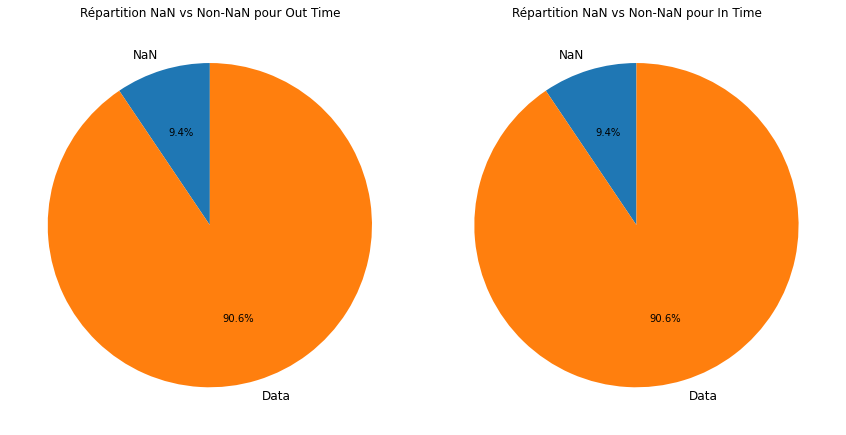

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Supposons que dfOut et dfIn sont déjà définis dans ton environnement de travail.

# Fonction pour calculer les pourcentages de NaN et non-NaN
def calc_nan_percentage(df):
    total_values = np.product(df.shape)
    nan_values = df.isnull().sum().sum()
    non_nan_values = total_values - nan_values
    return {'NaN': nan_values, 'Data': non_nan_values}

# Calcul des pourcentages pour dfOut et dfIn
out_nan_percentage = calc_nan_percentage(dfOut)
in_nan_percentage = calc_nan_percentage(dfIn)

# Création des pie charts
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart pour dfOut
ax[0].pie(out_nan_percentage.values(), labels=out_nan_percentage.keys(), autopct='%1.1f%%', startangle=90)
ax[0].set_title('Répartition NaN vs Non-NaN pour Out Time')

# Pie chart pour dfIn
ax[1].pie(in_nan_percentage.values(), labels=in_nan_percentage.keys(), autopct='%1.1f%%', startangle=90)
ax[1].set_title('Répartition NaN vs Non-NaN pour In Time')

plt.tight_layout()
plt.show()


### Conclusion
Nous avons maintenant un dataset prêt à être exploré et analysé. On remarque différents types de variables (discrètes et continues). 
Nous pourrions déjà imaginer à encoder les variables discrètes, afin de les utiliser avec notre modèle.

Nous avons donc:

|Variables Continues/Quantitatives|Variables Discrètes/Qualitatives|
|---|---|
|Age|BusinessTravel|
|DistanceFromHome|Department|
|MonthlyIncome|EducationField|
|EmployeeCount|Education|
|EmployeeID|Gender|
|NumCompaniesWorked|JobLevel|
|PercentSalaryHike|JobRole|
|StandardHours|JobInvolvement|
|TotalWorkingYears|MaritalStatus|
|TrainingTimesLastYear|Over18|
|YearsAtCompany|StockOptionLevel|
|YearsSinceLastPromotion|PerformanceRating|
|YearsWithCurrManager|EnvironmentSatisfaction|
|meanStartTime|JobSatisfaction|
|meanLeaveTime|WorkLifeBalance|
|meanPresenceTime||
|numberOfAbsenceDay||
|numberOfPresenceDay||

On y reviendra plus tard, mais on peut déjà remarquer variables sensibles ou inutiles : 
- **EmployeeCount**, **StandardHours**, **Over18** : ces features ne possèdent qu'une seule variable, nous ne pouvons pas en tirer des informations 
- **EmployeeID** : cette feature ne possède pas d'informations, elle était utilisé pour effectuer le 'merge' entre les différentes databases
- **Age**, **Gender**, **MaritalStatus** : ces features sont potentiellement sensibles, il faudra déterminer si nous souhaitons les garder


## Exploratory Data Analysis

### Objectif
- Comprendre du mieux possible nos données 
- Développer une première stratégie de modélisation

Nous allons garder le dataset complet durant cette partie. Nous pouvons analyser statistiquement les variables numériques à l'aide de "describe".

### Checklist de base

**Analyse de la forme:**
- Variable 'target' : Attrition
- Lignes et colonnes : 4410, 30
- Types de variables : 
    - continues : 15 
    - discrètes : 14
- Analyse des valeurs manquantes :
    - très peu de NaN (<0.1%)

**Analyse du fond:**

- **Visualisation de la 'target' :**
    - 16% de turnover (711 / 4410)
- **Signification des variables :**
    - On possède de nombreuses variables discrètes (prenant des valeurs allant de 1 à 5). 
        - 1 est la valeur la plus basse, ou la moins bonne 
        - 5 est la valeur la plus haute, ou la meilleure
    - Pour la feature 'MaritalStatus', la valeur 'Divorced' signifie que la personne a deja été mariée mais qu'elle est maintenant 'Single'.
- **Relation Variables / Target**:
    - Décrite après les graphiques liés.

### Analyse plus détaillée

**Hypothèse nulle (Ho):**
- Les jeunes (<35ans) ayant travaillé dans le domaine des ressources humaines sont plus susceptibles de partir.
    - H0 = Les jeunes ont un taux de turnover EGAL aux autres personnes plus agées.
        - **Rejetée** comme l'a montré notre T-TEST et notre analyse visuelle.
- Les personnes travaillant aux ressources humaines sont plus susceptibles de partir.
    - H0 = Les employés travaillant dans le domaine des ressources humaines ont un taux de turnover EGAL aux autres employés des autres domaines.
        - **Rejetée** comme l'a montré notre T-TEST et notre analyse visuelle. Toutefois, les résultats sont à prendre avec des pincettes, il n'y a que 198 personnes faisant partie de ce département.
- Les personnes travaillant plus sont plus susceptibles de partir.
    - H0 = Les personnes faisant des heures supplémentaires ont tout autant de risque de partir que les personnes n'en faisant pas.
        - **Rejetée** comme l'a montré notre T-TEST (*meanPresenceTime*) et notre analyse visuelle.

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'DistanceFromHome'}>,
        <Axes: title={'center': 'Education'}>,
        <Axes: title={'center': 'EmployeeCount'}>,
        <Axes: title={'center': 'EmployeeID'}>],
       [<Axes: title={'center': 'JobLevel'}>,
        <Axes: title={'center': 'MonthlyIncome'}>,
        <Axes: title={'center': 'NumCompaniesWorked'}>,
        <Axes: title={'center': 'PercentSalaryHike'}>,
        <Axes: title={'center': 'StandardHours'}>],
       [<Axes: title={'center': 'StockOptionLevel'}>,
        <Axes: title={'center': 'TotalWorkingYears'}>,
        <Axes: title={'center': 'TrainingTimesLastYear'}>,
        <Axes: title={'center': 'YearsAtCompany'}>,
        <Axes: title={'center': 'YearsSinceLastPromotion'}>],
       [<Axes: title={'center': 'YearsWithCurrManager'}>,
        <Axes: title={'center': 'JobInvolvement'}>,
        <Axes: title={'center': 'PerformanceRating'}>,
        <Axes: title={'center': 'EnvironmentSatisfa

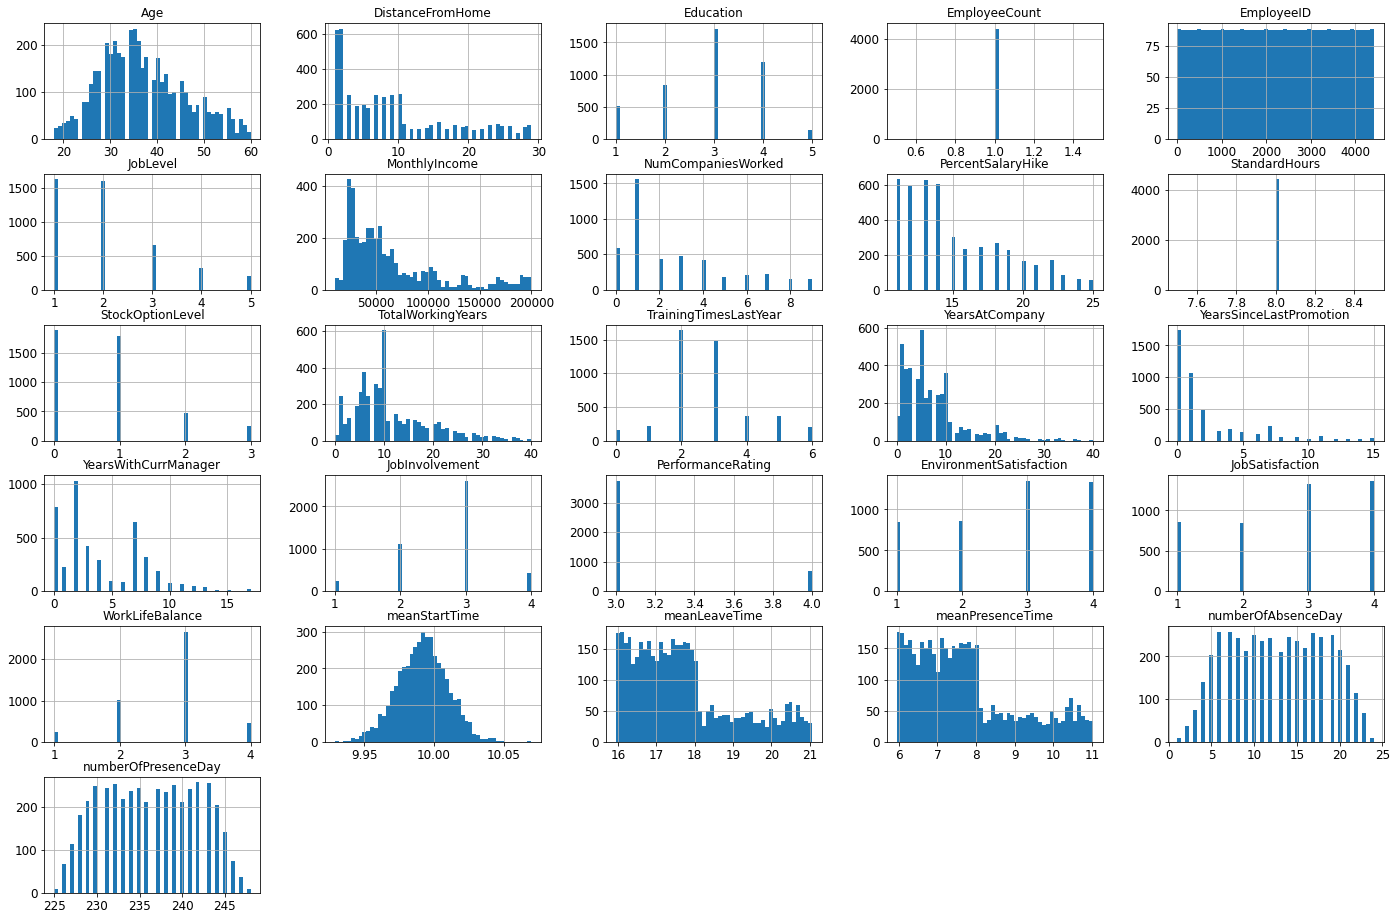

In [24]:
dataset.hist(bins=50, figsize = (24,16))

 De premiere vue on remarque qu'on peut eliminer certaines varibales qui n'ont aucune influence sur notre etude

In [25]:

dataset = dataset.drop(['EmployeeID', 'EmployeeCount', 'Over18', 'StandardHours'], axis=1)

In [26]:
dfIn.iloc[:, 1:] = dfIn.iloc[:, 1:].apply(pd.to_datetime, errors='coerce') # coerce va remplacer les erreurs par NaN ou NaT
dfOut.iloc[:, 1:] = dfOut.iloc[:, 1:].apply(pd.to_datetime, errors='coerce') # coerce va remplacer les erreurs par NaN ou NaT

dfOut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Columns: 262 entries, EmployeeID to 2015-12-31
dtypes: datetime64[ns](12), int64(1), object(249)
memory usage: 8.8+ MB


In [27]:
import pandas as pd

# Example conversion, replace with actual conversion as needed
def convert_to_datetime(x):
    # Assuming x is a string format that pd.to_datetime can handle, else adjust accordingly
    return pd.to_datetime(x, errors='coerce')  # 'coerce' will turn unparseable strings into NaT

def to_hour(x):
    return x.dt.hour + (x.dt.minute / 60)

# Apply conversion before applying to_hour
in_hour_df = dfIn.iloc[:, 1:].applymap(convert_to_datetime).apply(lambda x: to_hour(x))
out_hour_df = dfOut.iloc[:, 1:].applymap(convert_to_datetime).apply(lambda x: to_hour(x))

dataset["meanStartTime"] = in_hour_df.mean(axis=1)
dataset["meanLeaveTime"] = out_hour_df.mean(axis=1)

In [28]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   Gender                   4410 non-null   object 
 8   JobLevel                 4410 non-null   int64  
 9   JobRole                  4410 non-null   object 
 10  MaritalStatus            4410 non-null   object 
 11  MonthlyIncome            4410 non-null   int64  
 12  NumCompaniesWorked       4391 non-null   float64
 13  PercentSalaryHike        4410 non-null   int64  
 14  StockOptionLevel        

In [29]:
data_stats = dataset.copy()

data_stats.dropna(inplace=True)

In [30]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

enc = OneHotEncoder(handle_unknown='ignore')
cat_attribs = ["MaritalStatus", "JobRole", "Department"]
enc_df = pd.DataFrame(enc.fit_transform(data_stats[cat_attribs]).toarray())
enc_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4295,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4296,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4297,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4298,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'DistanceFromHome'}>,
        <Axes: title={'center': 'Education'}>,
        <Axes: title={'center': 'JobLevel'}>,
        <Axes: title={'center': 'MonthlyIncome'}>],
       [<Axes: title={'center': 'NumCompaniesWorked'}>,
        <Axes: title={'center': 'PercentSalaryHike'}>,
        <Axes: title={'center': 'StockOptionLevel'}>,
        <Axes: title={'center': 'TotalWorkingYears'}>,
        <Axes: title={'center': 'TrainingTimesLastYear'}>],
       [<Axes: title={'center': 'YearsAtCompany'}>,
        <Axes: title={'center': 'YearsSinceLastPromotion'}>,
        <Axes: title={'center': 'YearsWithCurrManager'}>,
        <Axes: title={'center': 'JobInvolvement'}>,
        <Axes: title={'center': 'PerformanceRating'}>],
       [<Axes: title={'center': 'EnvironmentSatisfaction'}>,
        <Axes: title={'center': 'JobSatisfaction'}>,
        <Axes: title={'center': 'WorkLifeBalance'}>,
        <Axes: title={'center': 'm

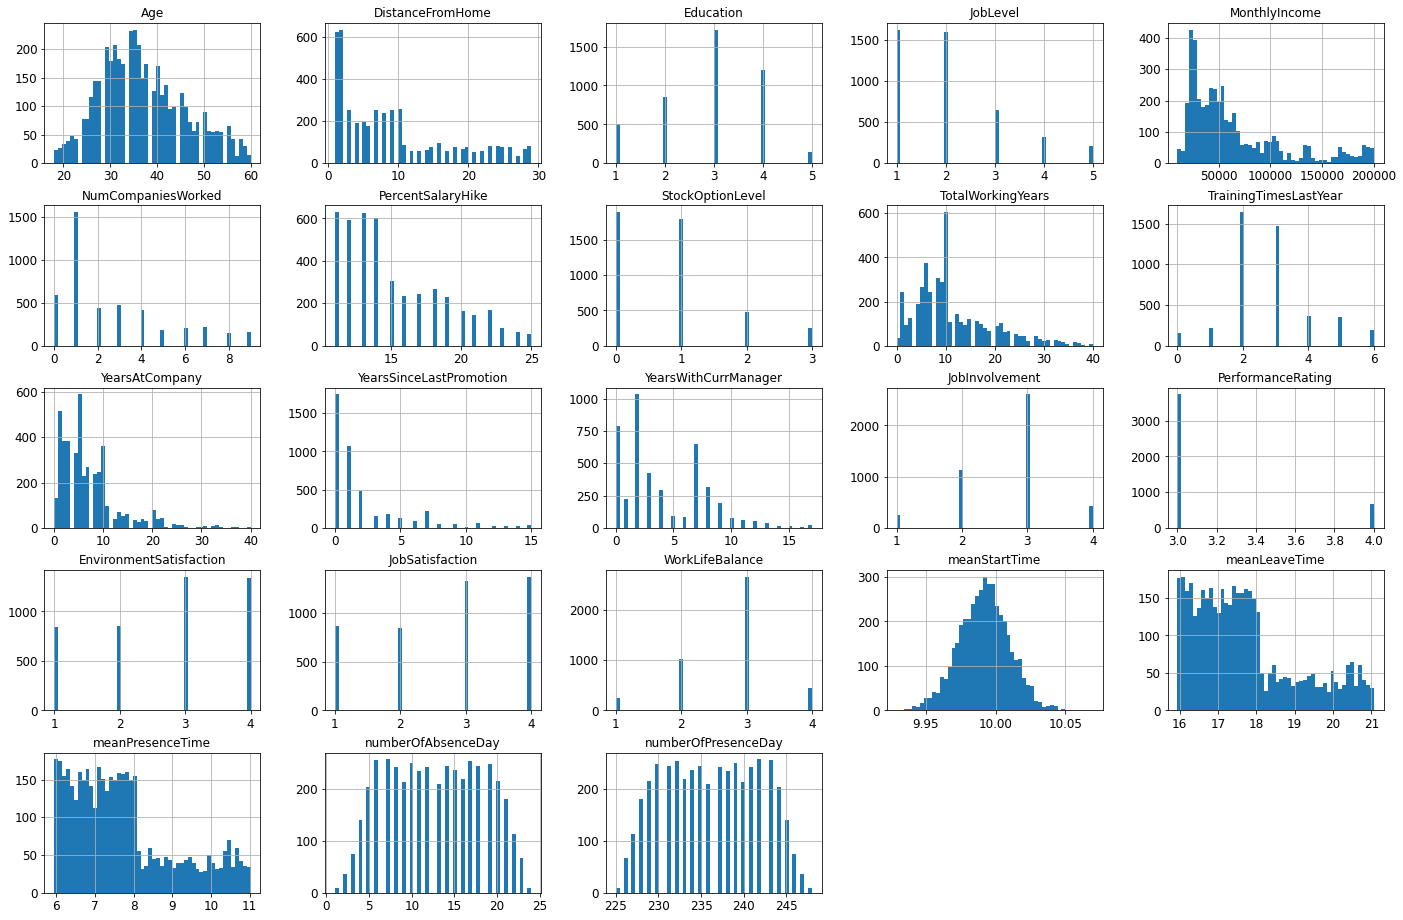

In [31]:
dataset.hist(bins=50, figsize = (24,16))

### Analyse de nos datas

Nous pouvons analyser les données obtenues pour essayer de déceler les attributs les plus pertinents par exemple ou simplement pour se mettre au courant de l'architecture du dataset sur lequel nous allons travailler.

### ANOVA

In [32]:
cont = ['Age','DistanceFromHome','MonthlyIncome','NumCompaniesWorked','PercentSalaryHike','TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany','YearsSinceLastPromotion','YearsWithCurrManager','meanStartTime','meanLeaveTime','meanPresenceTime','numberOfAbsenceDay', 'numberOfPresenceDay']

disc = ['EducationField', 'BusinessTravel', 'Department', 'Education', 'JobLevel', 'JobRole', 'JobInvolvement', 'StockOptionLevel', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'MaritalStatus']

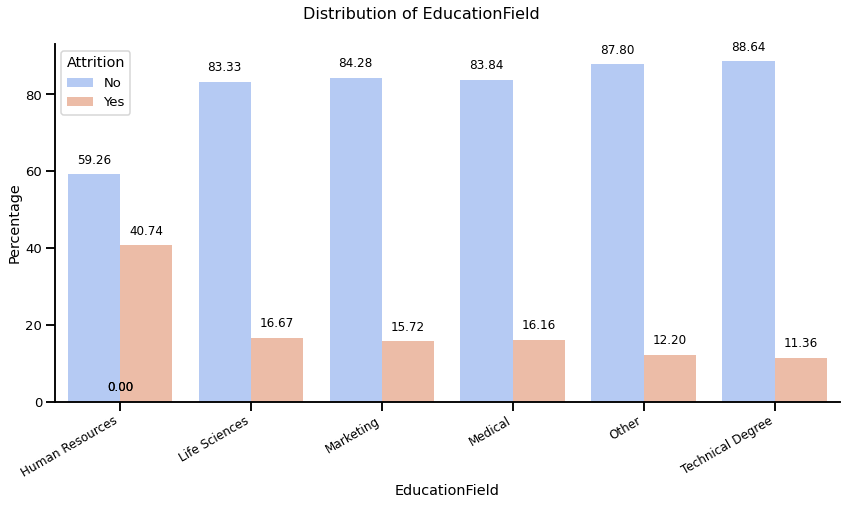

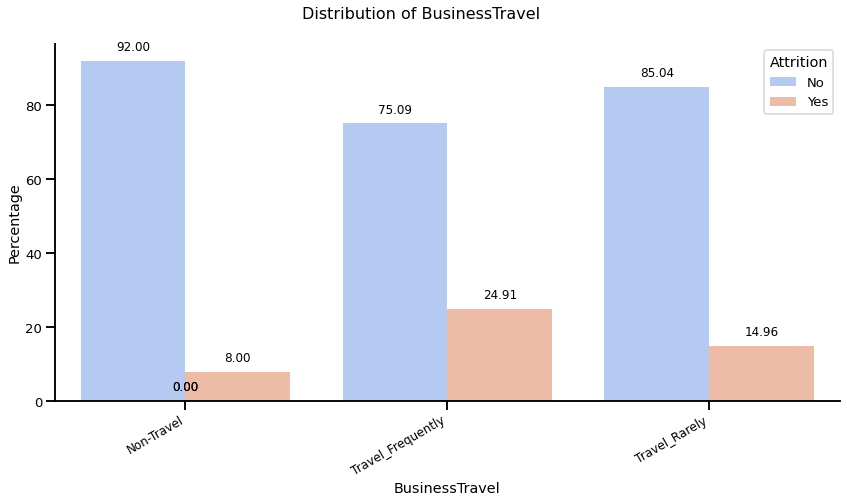

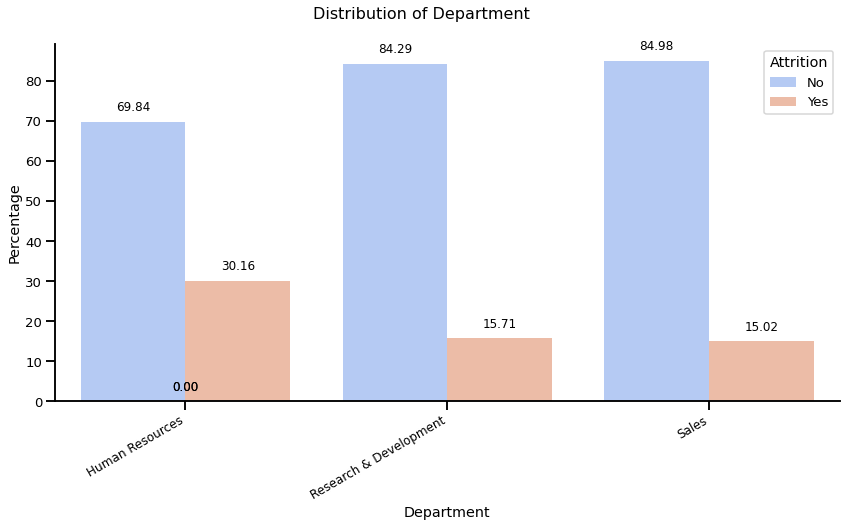

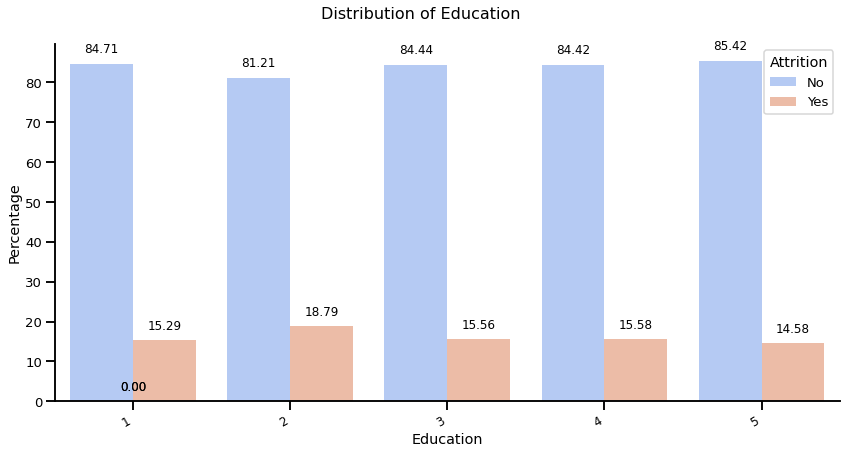

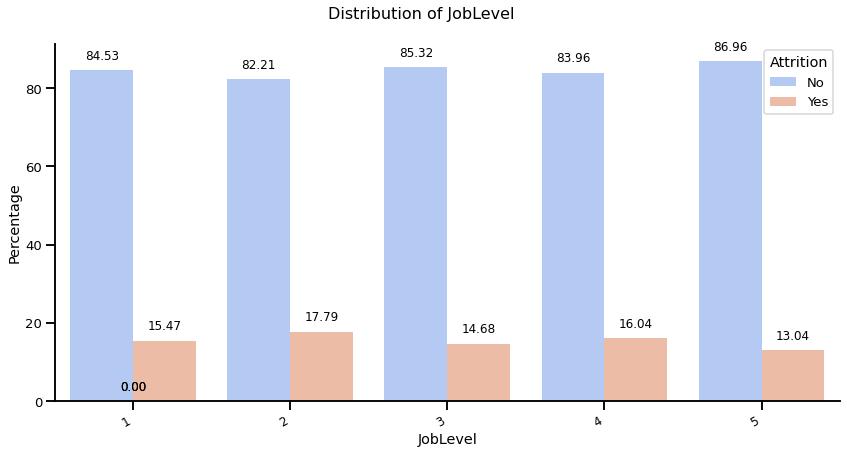

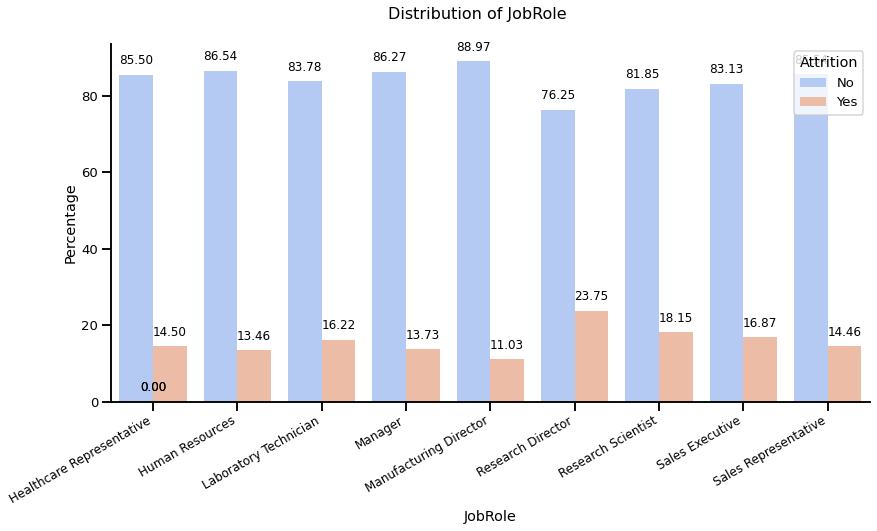

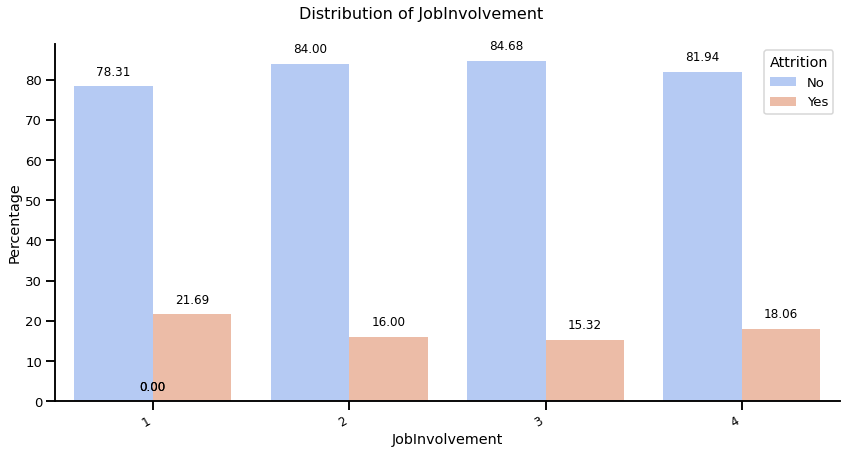

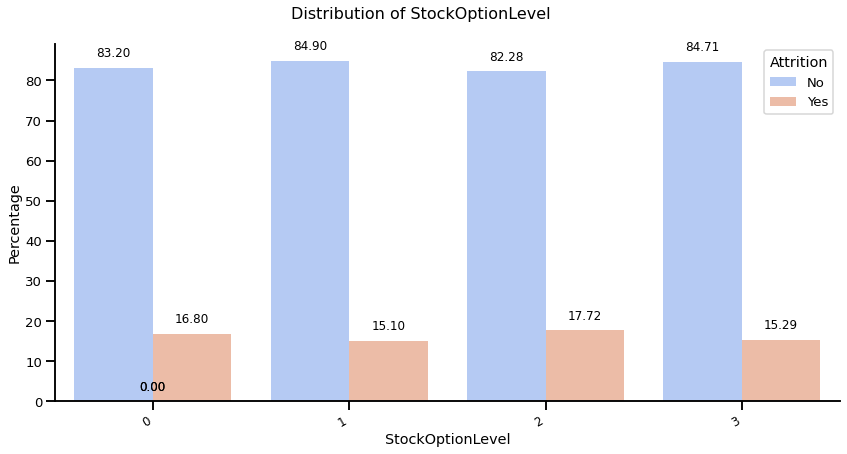

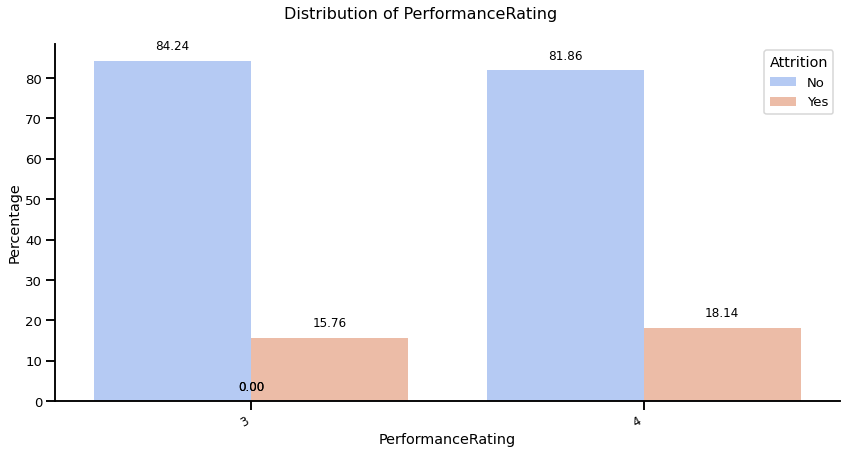

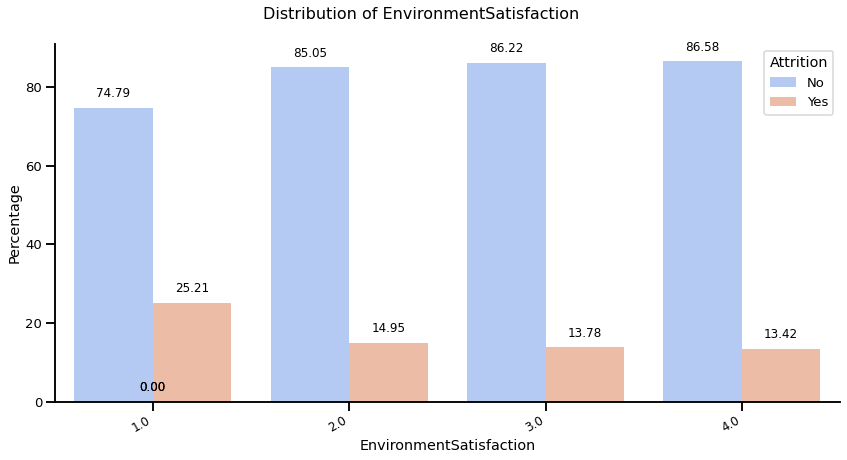

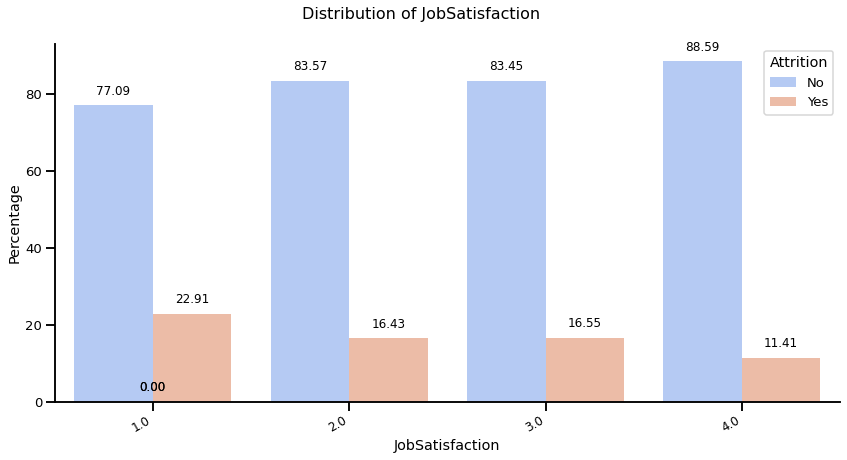

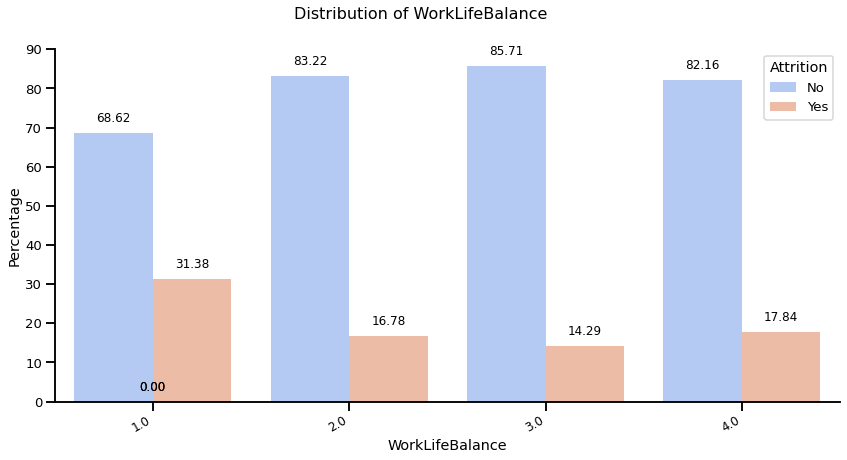

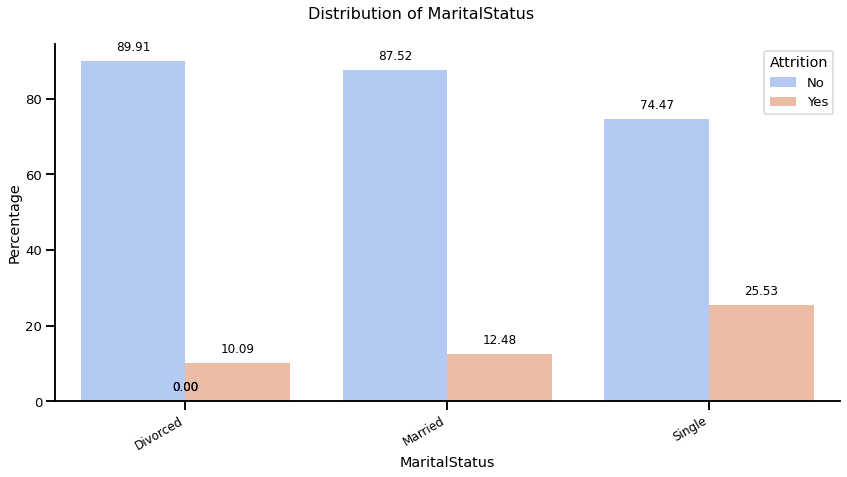

In [33]:
import seaborn as sns

def add_annotation(cat, c):
    x1 = c.get_x() + c.get_width() / 2 
    y1 = c.get_y() + c.get_height() + 2
    cat.ax.annotate(format(c.get_height(), '.2f'), (x1, y1), ha='center', va='bottom', size=12)

def plot_hist(column, df, annot=True):
    x_name = column
    y_name = 'Attrition'

    temp_data = (df
     .groupby(x_name)[y_name]
     .value_counts(normalize=True)
     .mul(100)
     .rename('percent')
     .reset_index())

    sns.set_context('talk', font_scale=0.8)
    
    catp = sns.catplot(data=temp_data, x=x_name, y='percent', hue=y_name, kind='bar', height=6, aspect=2, palette='coolwarm', legend_out=False)

    catp.set_xticklabels(rotation=30, horizontalalignment='right', fontsize=12)
    catp.set_axis_labels(x_name, 'Percentage')
    catp.fig.suptitle(f'Distribution of {x_name} ', fontsize=16, y=1.05)  # Adjust the title positioning

    if annot:
        spots = catp.ax.patches
        for c in spots:
            add_annotation(catp, c)
    

hue_order = ['No', 'Yes']  # Assuming 'Attrition' column has values like 'No' and 'Yes'
for name in disc:
        plot_hist(name, dataset)

### KHI-DEUX

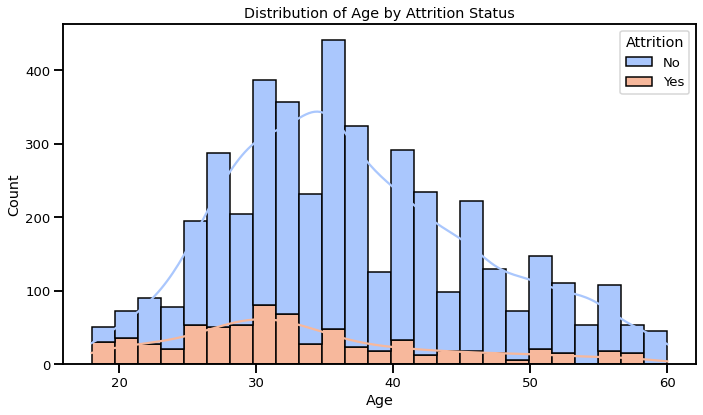

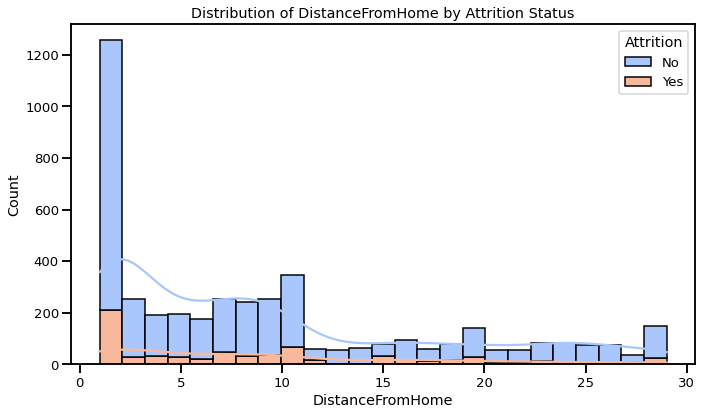

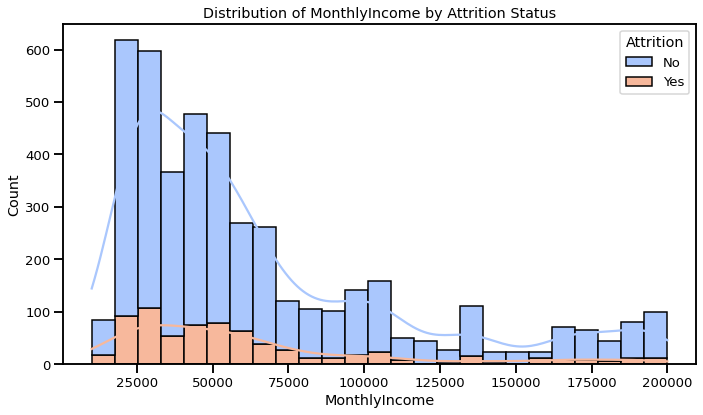

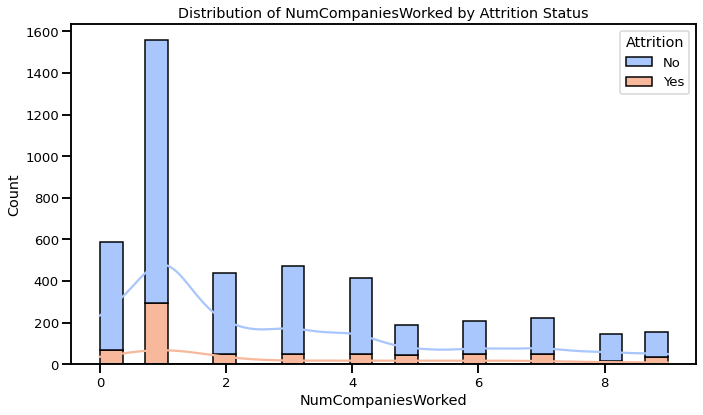

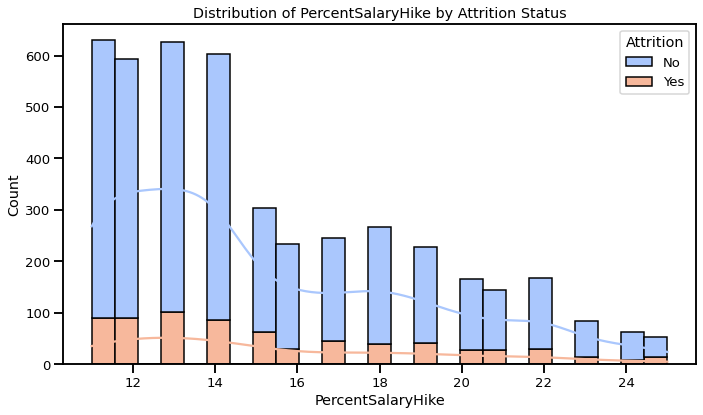

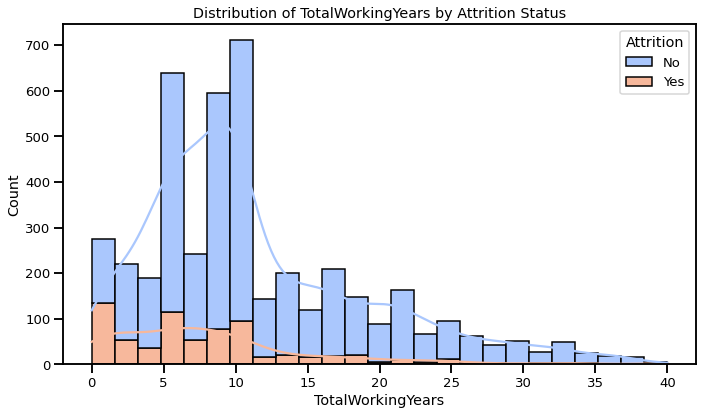

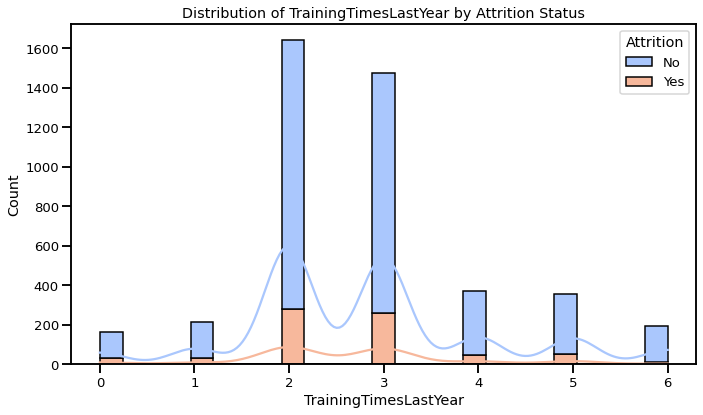

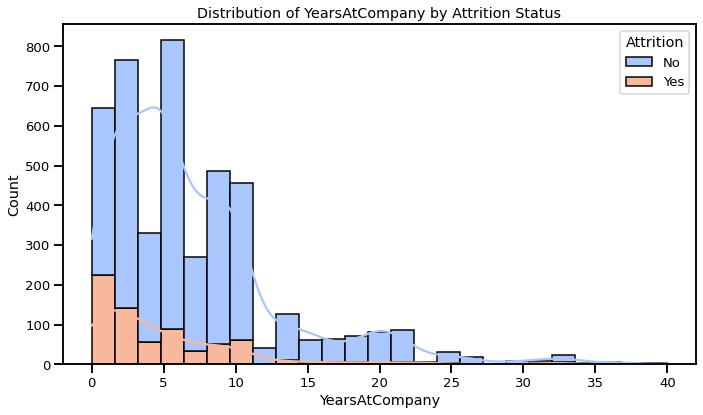

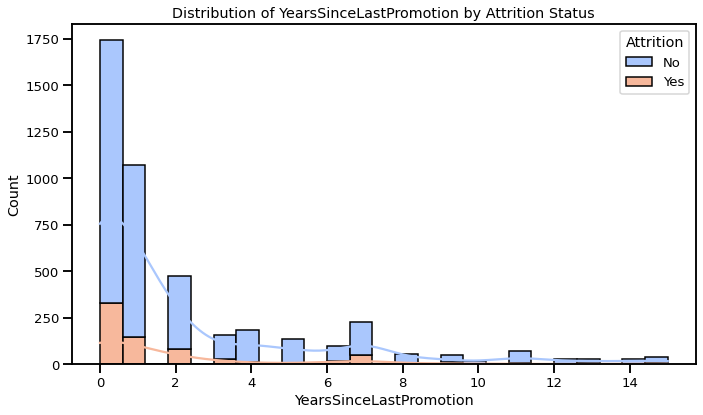

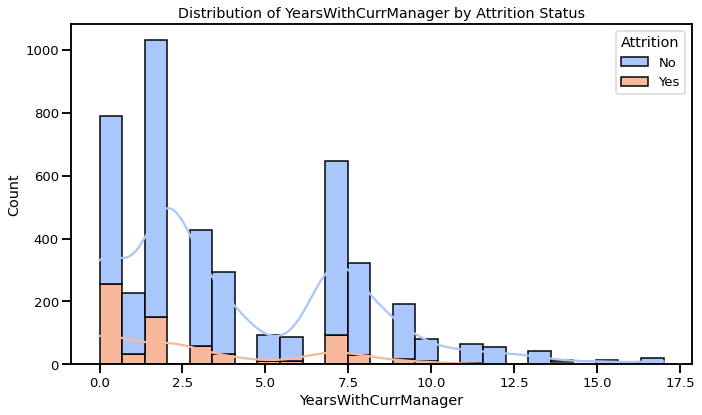

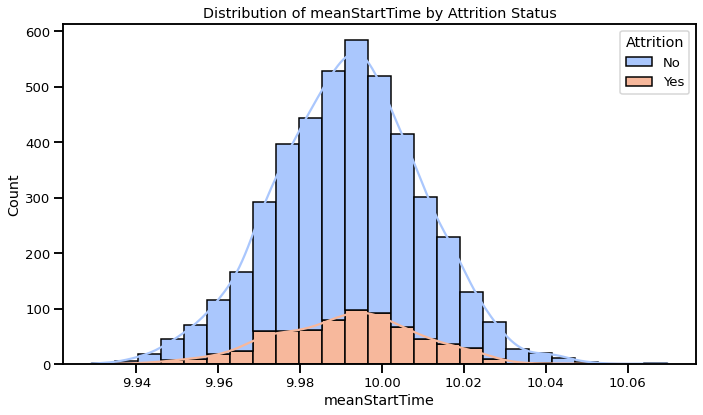

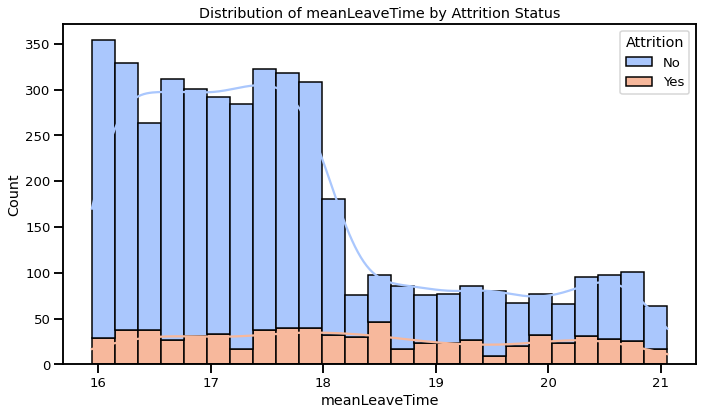

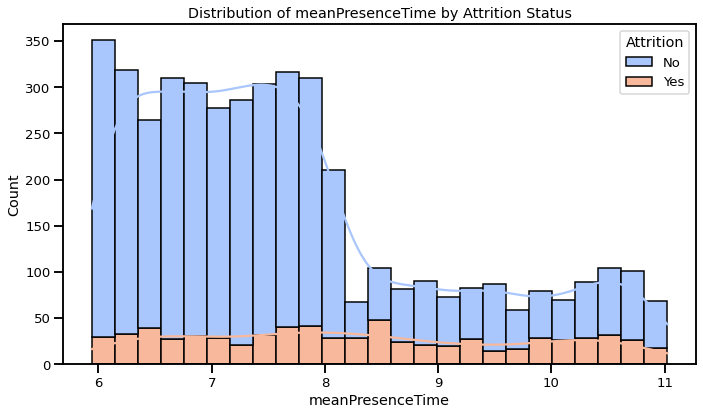

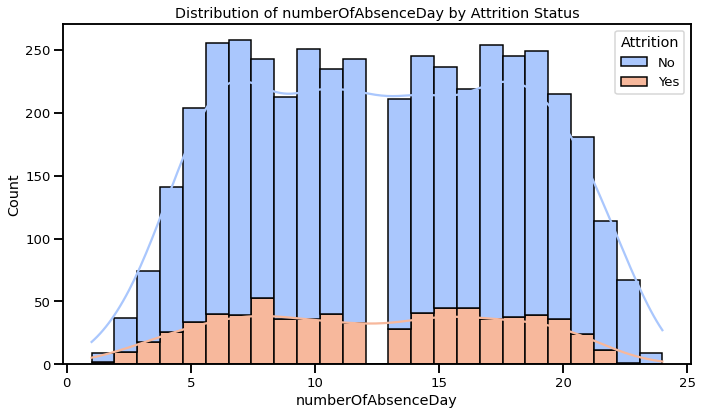

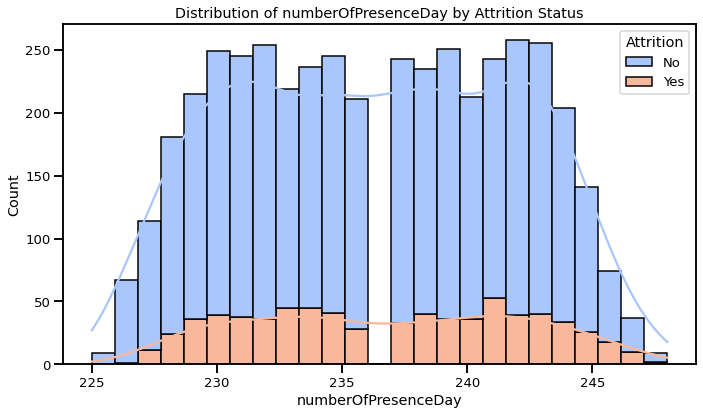

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt


for name in cont:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=dataset, x=name, hue="Attrition", multiple="stack", kde=True, bins=25, palette='coolwarm', alpha=1)  
    plt.title(f'Distribution of {name} by Attrition Status') 
    plt.tight_layout()  
    plt.show()

## **Corrélation Inter-données**
Sachant que nous chercherons à prédire l'attrition, il parait intéréssant de voir quelles sont les données les plus corrélées avec cette dernière, nous allons donc monter une matrice de corrélation sur le jeu de données global.

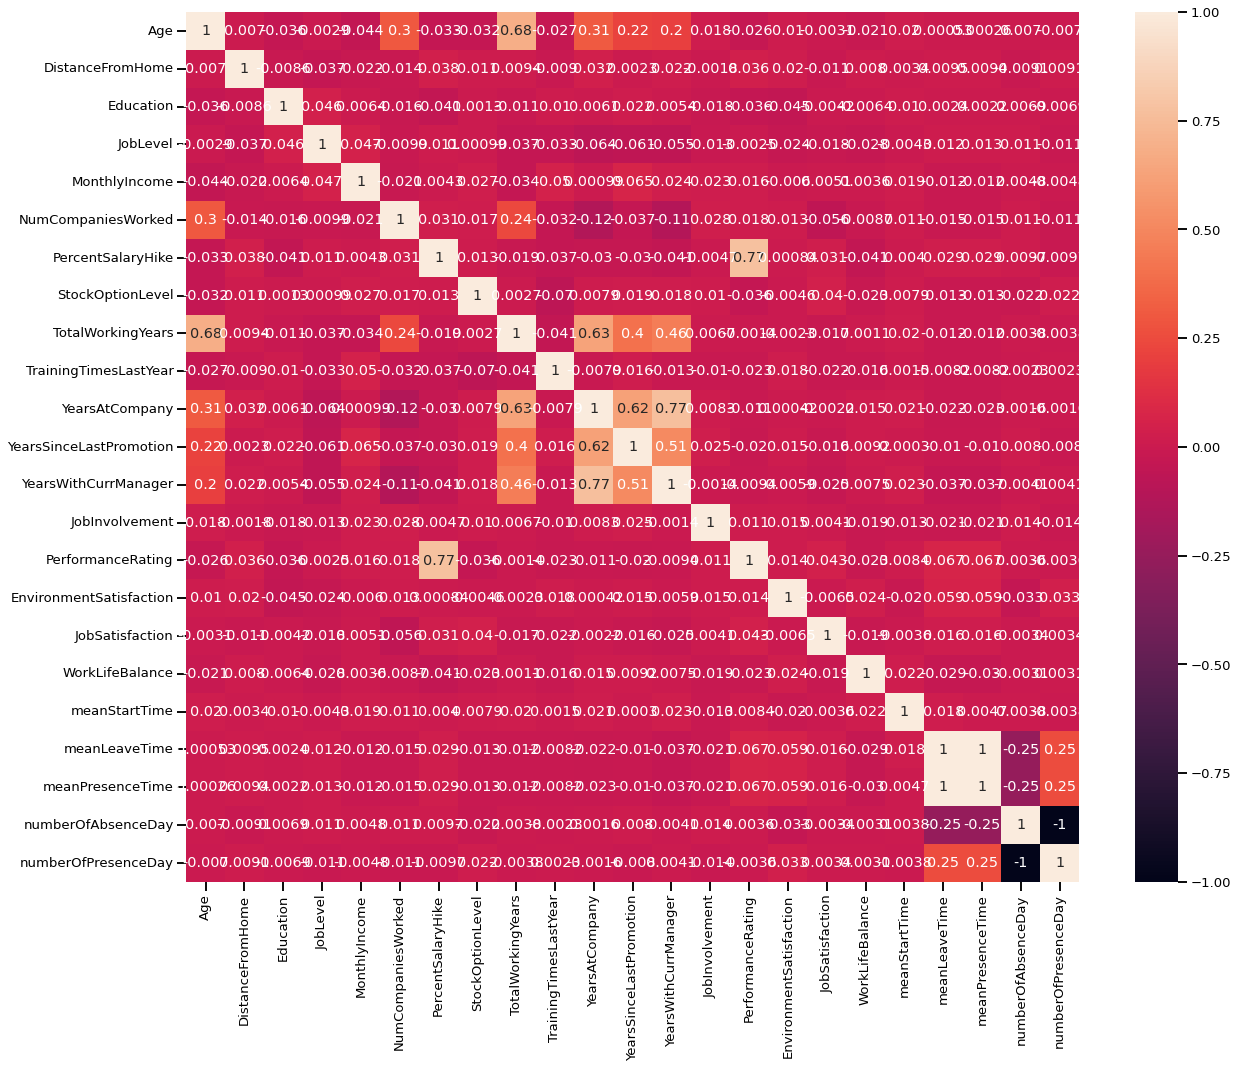

In [35]:
#changed


import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation matrix
numeric_dataset = dataset.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix on the numeric dataset
corrMatrix = numeric_dataset.corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corrMatrix, annot=True)
plt.show()


### Préparation de nos datasets (Pipeline)

Les datas sont prêtes à être exploité et pour cela on commence par les transformer à notre guise.

Nous allons pouvoir créer une pipeline qui serait la résultante de tous les autres (réalisés dans le bon ordre) et ainsi avoir un contrôle  sur nos données en prévisions de nos plans de lecture.


Pour cela nous utiliserons des pipelines de données customisées qui nous retournerons nos jeux de données customisés et valorisés.

In [36]:
from sklearn.preprocessing import OrdinalEncoder , LabelEncoder

label_encoder = LabelEncoder()
dataset["Attrition"] = label_encoder.fit_transform(dataset["Attrition"])

# Sélectionner toutes les colonnes sauf EmployeeID et Attrition
cat_cols = [col for col in dataset.columns if col not in [ "Attrition"]]
dataset_quant = dataset[cat_cols]

# Encoder les variables catégorielles avec l'encodage ordinal
ordinal_encoder = OrdinalEncoder()
dataset_encoded = ordinal_encoder.fit_transform(dataset_quant)
dataset_encoded = pd.DataFrame(dataset_encoded, columns=cat_cols)

# Ajouter les colonnes "EmployeeID" et "Attrition"
dataset_encoded["Attrition"] = dataset["Attrition"]

In [37]:
from sklearn.impute import KNNImputer
knn = dataset[['NumCompaniesWorked', 'TotalWorkingYears', 'EnvironmentSatisfaction',
               'JobSatisfaction', 'WorkLifeBalance']]

imputer = KNNImputer(n_neighbors=10)
imputer.fit_transform(knn)
complete_rows = pd.DataFrame(imputer.fit_transform(knn), columns=knn.columns.values)
dataset.update(complete_rows)
dataset.update(dataset_encoded)
dataset.head(50)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,meanStartTime,meanLeaveTime,meanPresenceTime,numberOfAbsenceDay,numberOfPresenceDay
0,33,0,2.0,2.0,5,1,1.0,0.0,0,0.0,...,2,0,2.0,3.0,1.0,2112.0,2115.0,2106.0,16,7
1,13,1,1.0,1.0,9,0,1.0,0.0,0,6.0,...,1,1,2.0,1.0,3.0,1116.0,2641.0,2683.0,12,11
2,14,0,1.0,1.0,16,3,4.0,1.0,3,7.0,...,2,0,1.0,1.0,0.0,3696.0,1632.0,1606.0,6,17
3,20,0,0.0,1.0,1,4,1.0,1.0,2,1.0,...,1,0,3.0,3.0,2.0,679.0,1833.0,1862.0,13,10
4,14,0,2.0,1.0,9,0,3.0,1.0,0,7.0,...,2,0,3.0,0.0,2.0,1839.0,3083.0,3100.0,3,20
5,28,0,2.0,1.0,7,2,1.0,0.0,3,5.0,...,2,0,2.0,1.0,1.0,1102.0,4301.0,4302.0,11,12
6,10,1,2.0,1.0,10,1,3.0,1.0,1,7.0,...,2,1,0.0,2.0,0.0,122.0,1441.0,1515.0,16,7
7,11,0,2.0,1.0,17,2,1.0,1.0,1,7.0,...,2,1,0.0,1.0,2.0,2222.0,1204.0,1213.0,5,18
8,13,0,2.0,1.0,0,2,1.0,1.0,2,2.0,...,2,1,1.0,3.0,2.0,3586.0,1965.0,1949.0,18,5
9,7,0,0.0,1.0,6,3,3.0,0.0,3,2.0,...,2,0,1.0,0.0,2.0,135.0,1639.0,1677.0,14,9


In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   int32  
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   Gender                   4410 non-null   object 
 8   JobLevel                 4410 non-null   int64  
 9   JobRole                  4410 non-null   object 
 10  MaritalStatus            4410 non-null   object 
 11  MonthlyIncome            4410 non-null   int64  
 12  NumCompaniesWorked       4410 non-null   float64
 13  PercentSalaryHike        4410 non-null   int64  
 14  StockOptionLevel        

### Split

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_index, test_index in split.split(dataset, dataset["Attrition"]):
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]

In [40]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3528 entries, 3465 to 1125
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      3528 non-null   int64  
 1   Attrition                3528 non-null   int32  
 2   BusinessTravel           3528 non-null   object 
 3   Department               3528 non-null   object 
 4   DistanceFromHome         3528 non-null   int64  
 5   Education                3528 non-null   int64  
 6   EducationField           3528 non-null   object 
 7   Gender                   3528 non-null   object 
 8   JobLevel                 3528 non-null   int64  
 9   JobRole                  3528 non-null   object 
 10  MaritalStatus            3528 non-null   object 
 11  MonthlyIncome            3528 non-null   int64  
 12  NumCompaniesWorked       3528 non-null   float64
 13  PercentSalaryHike        3528 non-null   int64  
 14  StockOptionLevel         3

In [41]:
X_train = strat_train_set.drop("Attrition", axis=1)
Y_train = strat_train_set["Attrition"].copy()

X_test = strat_test_set.drop("Attrition", axis=1)
Y_test = strat_test_set["Attrition"].copy()

# Les Modèles



**SGD (Stochastique Gradient Descent) :** Gradient stochastique est une approximation de la descente de gradient, applicable lorsque la fonction objectif s’écrit comme une somme de fonctions dérivables : c’est très souvent le cas en apprentissage supervisé.

**Decision Tree :** Un arbre de décision permet d'expliquer une variable cible à partir d'autres variables dites explicatives. Pour ce faire, l'algorithme va séparer les individus en k groupes (généralement k=2 et on parle d’arbre binaire) pour expliquer la variable cible. La première division (on parle aussi de split) est obtenue en choisissant la variable explicative qui permet la meilleure séparation des individus. Cette division donne des sous-populations correspondant au premier nœud de l'arbre.

**Random Forest :** Les forêts d’arbres décisionnels ou forêts aléatoires (Random Forest) sont une technique d’apprentissage ensembliste qui s’appuie sur des arbres de décision. Le modèle random forest implique la création d’arbres décisionnels (decision tree) multiples en utilisant ensembles de données fractionnés à partir des données d’origine. Et en sélectionnant aléatoirement un sous-ensemble de variables à chaque étape de l’arbre décisionnel. Le modèle sélectionne ensuite le mode de toutes les prédictions de chaque arbre décisionnel.

**Regression Logistique :** La régression logistique est semblable à la régression linéaire, mais elle est utilisée pour modéliser la probabilité d’un nombre fini de résultats, généralement deux. Une équation logistique est créée de telle sorte que les valeurs des résultats ne peuvent être qu’entre 0 et 1.

**Perceptron :** Le perceptron est un algorithme d’apprentissage supervisé de classifieurs binaires (séparant deux classes). Il s’agit alors d’un type de classifieur linéaire, et du type de réseau de neurones artificiels le plus simple.

###  Perceptron

In [67]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import f1_score, precision_score, recall_score
import time
start_time_cpu_p = time.time()

perceptron = Perceptron()

start_time_cpu_rl = time.time()

# Entraîner le modèle sur les données d'entraînement
perceptron.fit(X_train, Y_train)

# Faire des prédictions sur les données de test
test_predictions = perceptron.predict(X_test)

# Calculer le F1-score, la précision et le recall sur les données de test
test_f1 = f1_score(Y_test, test_predictions)
test_precision = precision_score(Y_test, test_predictions)
test_recall = recall_score(Y_test, test_predictions)

# Calculer l'accuracy sur les données de test
test_accuracy = perceptron.score(X_test, Y_test)

print("Accuracy on test data:", test_accuracy)
print("F1-score on test data:", test_f1)
print("Precision on test data:", test_precision)
print("Recall on test data:", test_recall)

end_time_cpu_p = time.time()
time_cpu_p = end_time_cpu_p - start_time_cpu_p
nombre_cpu_p = round(time_cpu_p, 2)
print(f"Temps d'exécution CPU de la cellule: {nombre_cpu_p} secondes")


Accuracy on test data: 0.8219954648526077
F1-score on test data: 0.08187134502923975
Precision on test data: 0.2413793103448276
Recall on test data: 0.04929577464788732
Temps d'exécution CPU de la cellule: 0.06 secondes


### RANDOM SEARCH
La recherche aléatoire est une technique d'optimisation d'hyperparamètres utilisée en apprentissage automatique et en apprentissage en profondeur. Elle consiste à sélectionner des combinaisons aléatoires d'hyperparamètres et à évaluer leurs performances sur un ensemble de validation.

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Assuming 'perceptron' is your Perceptron model instance and X_train, Y_train are defined
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Changed 'none' to None
    'alpha': uniform(0.0001, 0.1),
    'max_iter': [1000, 5000, 10000],
}

random_search = RandomizedSearchCV(perceptron, param_distributions=param_dist, cv=5, n_iter=10, random_state=42)
random_search.fit(X_train, Y_train)


RandomizedSearchCV(cv=5, estimator=Perceptron(),
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002036A58A8E0>,
                                        'max_iter': [1000, 5000, 10000],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    None]},
                   random_state=42)

In [44]:
print(random_search.best_params_)

{'alpha': 0.030524224295953774, 'max_iter': 5000, 'penalty': 'l1'}


In [45]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import f1_score, precision_score, recall_score

# Assuming X_train, Y_train, X_test, Y_test are already defined

# Correctly instantiate the Perceptron model with `None` for the `penalty` parameter
perceptron_rs = Perceptron(alpha=0.0059083612168199465, max_iter=1000, penalty=None)

# Train the model on the training data
perceptron_rs.fit(X_train, Y_train)

# Make predictions on the test data
test_predictions_rs = perceptron_rs.predict(X_test)

# Calculate the F1-score, precision, and recall on the test data
test_f1 = f1_score(Y_test, test_predictions_rs)
test_precision = precision_score(Y_test, test_predictions_rs)
test_recall = recall_score(Y_test, test_predictions_rs)

# Calculate accuracy on the test data
test_accuracy = perceptron_rs.score(X_test, Y_test)

# Print the evaluation metrics
print("Accuracy on test data:", test_accuracy)
print("F1-score on test data:", test_f1)
print("Precision on test data:", test_precision)
print("Recall on test data:", test_recall)


Accuracy on test data: 0.8219954648526077
F1-score on test data: 0.08187134502923975
Precision on test data: 0.2413793103448276
Recall on test data: 0.04929577464788732


### Grid Search
La recherche par grille (ou grid search en anglais) est une technique d'optimisation d'hyperparamètres utilisée en apprentissage automatique et en apprentissage en profondeur. Elle consiste à définir un ensemble de valeurs possibles pour chaque hyperparamètre à optimiser, puis à évaluer toutes les combinaisons possibles de ces valeurs sur un ensemble de validation. Cette méthode permet de trouver l'ensemble optimal d'hyperparamètres en explorant systématiquement l'espace des combinaisons possibles. Cependant, elle peut être coûteuse en temps de calcul si l'espace des hyperparamètres est grand et complexe.

In [46]:
from sklearn.model_selection import GridSearchCV

pt_gs = Perceptron(tol=1e-3, random_state=42)
pt_gs.fit(X_train,Y_train)

pt_param_grid = {
    'penalty' : ['l1', 'l2', 'elasticnet'],
    'fit_intercept': [True, False],
    'max_iter': [500, 1000, 1500, 2000, 2500]

}
pt_grid = GridSearchCV(pt_gs, pt_param_grid, cv=10, scoring='f1', return_train_score=True)
pt_grid.fit(X_train, Y_train)
pt = pt_grid.best_estimator_

print(pt_grid.best_params_)

{'fit_intercept': True, 'max_iter': 500, 'penalty': 'l2'}


In [47]:
#changed

perceptron_gs = Perceptron(  max_iter= 500, penalty='l1',fit_intercept=True)

# Entraîner le modèle sur les données d'entraînement
perceptron_gs.fit(X_train, Y_train)

# Faire des prédictions sur les données de test
test_predictions_gs = perceptron_rs.predict(X_test)

# Calculer le F1-score, la précision et le recall sur les données de test
test_f1 = f1_score(Y_test, test_predictions_gs)
test_precision = precision_score(Y_test, test_predictions_gs)
test_recall = recall_score(Y_test, test_predictions_gs)

# Calculer l'accuracy sur les données de test
test_accuracy = perceptron_gs.score(X_test, Y_test)

print("Accuracy on test data:", test_accuracy)
print("F1-score on test data:", test_f1)
print("Precision on test data:", test_precision)
print("Recall on test data:", test_recall)

Accuracy on test data: 0.16326530612244897
F1-score on test data: 0.08187134502923975
Precision on test data: 0.2413793103448276
Recall on test data: 0.04929577464788732


## Stochastique Gradient Descent

In [68]:

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
import time 
start_time_cpu_sgd = time.time()

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
test_predictions = sgd.predict(X_test)

# Calculer le F1-score, la précision et le recall sur les données de test
test_f1 = f1_score(Y_test, test_predictions)
test_precision = precision_score(Y_test, test_predictions)
test_recall = recall_score(Y_test, test_predictions)

# Calculer l'accuracy sur les données de test
test_accuracy =sgd.score(X_test, Y_test)

print("Accuracy on test data:", test_accuracy)
print("F1-score on test data:", test_f1)
print("Precision on test data:", test_precision)
print("Recall on test data:", test_recall)
end_time_cpu_sgd = time.time()
time_cpu_sgd = end_time_cpu_sgd - start_time_cpu_sgd
nombre_cpu_sgd = round(time_cpu_sgd, 2)
print(f"Temps d'exécution CPU de la cellule: {nombre_cpu_sgd} secondes")



Accuracy on test data: 0.336734693877551
F1-score on test data: 0.29940119760479045
Precision on test data: 0.18037518037518038
Recall on test data: 0.8802816901408451
Temps d'exécution CPU de la cellule: 0.14 secondes


### Random Search

In [69]:
#Changed

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from scipy.stats import uniform
import time
start_time_cpu_rs = time.time()
param_dist = {
    'alpha': uniform(0.0001, 0.1),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'loss': ['hinge', 'log_loss', 'modified_huber']  # Corrected 'log' to 'log_loss'
}

# Perform the random search
sgd_random_search = RandomizedSearchCV(sgd, param_distributions=param_dist, n_iter=50, cv=5, random_state=42)
sgd_random_search.fit(X_train, Y_train)

# Display the best hyperparameters found
print('Best hyperparameters:', sgd_random_search.best_params_)
print('Best score:', sgd_random_search.best_score_)
end_time_cpu_rs = time.time()
time_cpu_rs = end_time_cpu_rs - start_time_cpu_rs
nombre_cpu_rs = round(time_cpu_rs, 2)
print(f"Temps d'exécution CPU de la cellule: {nombre_cpu_rs} secondes")



Best hyperparameters: {'alpha': 0.037554011884736255, 'loss': 'hinge', 'penalty': 'elasticnet'}
Best score: 0.8384340907721054
Temps d'exécution CPU de la cellule: 9.57 secondes


c:\Users\lamra\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
105 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lamra\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lamra\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "c:\Users\lamra\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 649, in _fit
    self._validate_params()
  File "c:\Users\lamra\ana

In [50]:
sgd_rs = SGDClassifier(alpha=0.0457069984217036, loss='modified_huber', penalty='l2')
sgd_rs.fit(X_train, Y_train)
test_predictions_rs = sgd_rs.predict(X_test)

# Calculer le F1-score, la précision et le recall sur les données de test
test_f1 = f1_score(Y_test, test_predictions_rs)
test_precision = precision_score(Y_test, test_predictions_rs)
test_recall = recall_score(Y_test, test_predictions_rs)

# Calculer l'accuracy sur les données de test
test_accuracy =sgd_rs.score(X_test, Y_test)

print("Accuracy on test data:", test_accuracy)
print("F1-score on test data:", test_f1)
print("Precision on test data:", test_precision)
print("Recall on test data:", test_recall)


c:\Users\lamra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test data: 0.8390022675736961
F1-score on test data: 0.0
Precision on test data: 0.0
Recall on test data: 0.0


### Grid Search

In [51]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Initialisation du SGDClassifier avec un max_iter ajusté
sgd = SGDClassifier(max_iter=1000)  # Réduit pour équilibrer le temps d'exécution et la convergence

# Définition de la grille de paramètres (réduite pour diminuer le temps de calcul)
sgd_param_grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1],  # Plage réduite pour exemple
    'loss': ['hinge', 'log_loss'],  # Sélection de deux pertes représentatives
    'penalty': ['l1', 'l2']  # Utilisation des pénalités les plus courantes
}

# Création du GridSearchCV avec réduction du nombre de plis de validation croisée et utilisation de tous les cœurs disponibles
sgd_grid = GridSearchCV(sgd, sgd_param_grid, cv=5, scoring='f1', return_train_score=True, n_jobs=-1)

# Entraînement avec GridSearchCV
sgd_grid.fit(X_train, Y_train)

# Affichage des meilleurs paramètres
print('Best parameters:', sgd_grid.best_params_)


Best parameters: {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l1'}


c:\Users\lamra\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lamra\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lamra\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "c:\Users\lamra\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 649, in _fit
    self._validate_params()
  File "c:\Users\lamra\anacon

In [52]:
sgd_gs = SGDClassifier(alpha=0.001, loss='squared_hinge', penalty='l1')
sgd_gs.fit(X_train, Y_train)
test_predictions_gs = sgd_gs.predict(X_test)

# Calculer le F1-score, la précision et le recall sur les données de test
test_f1 = f1_score(Y_test, test_predictions_gs)
test_precision = precision_score(Y_test, test_predictions_gs)
test_recall = recall_score(Y_test, test_predictions_gs)

# Calculer l'accuracy sur les données de test
test_accuracy =sgd_gs.score(X_test, Y_test)

print("Accuracy on test data:", test_accuracy)
print("F1-score on test data:", test_f1)
print("Precision on test data:", test_precision)
print("Recall on test data:", test_recall)

Accuracy on test data: 0.8378684807256236
F1-score on test data: 0.13333333333333333
Precision on test data: 0.4782608695652174
Recall on test data: 0.07746478873239436


### Regression Logistique

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time 

start_time_cpu_rl = time.time()


# Assurez-vous que X_train, Y_train, X_test, et Y_test sont définis
lr = LogisticRegression()
lr.fit(X_train, Y_train)

test_predictions = lr.predict(X_test)

# Calcul des métriques
test_f1 = f1_score(Y_test, test_predictions)
test_precision = precision_score(Y_test, test_predictions)
test_recall = recall_score(Y_test, test_predictions)

# Affichage des résultats
print("F1-score on test data:", test_f1)
print("Precision on test data:", test_precision)
print("Recall on test data:", test_recall)
print("Coefficients:", lr.coef_)

end_time_cpu_rl = time.time()
time_cpu_rl = end_time_cpu_rl - start_time_cpu_rl
nombre_cpu_rl = round(time_cpu_rl, 2)
print(f"Temps d'exécution CPU de la cellule: {nombre_cpu_rl} secondes")




F1-score on test data: 0.14012738853503184
Precision on test data: 0.7333333333333333
Recall on test data: 0.07746478873239436
Coefficients: [[-0.03714157 -0.01190213 -0.0255695  -0.00605246 -0.01356542 -0.04474686
   0.00121169 -0.02667542  0.0152079   0.05613481  0.00010554  0.0969078
  -0.00646251 -0.0131976  -0.02129157 -0.05600843 -0.04689278  0.09728773
  -0.08233446 -0.00829649 -0.00119454 -0.0844602  -0.09135756 -0.03931821
   0.00018509 -0.00675505  0.00727601 -0.08246151 -0.07079863]]
Temps d'exécution CPU de la cellule: 0.16 secondes


c:\Users\lamra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Arbre de decision

In [54]:
from sklearn.tree import DecisionTreeClassifier
import time 
start_time_cpu_add = time.time()

dt = DecisionTreeClassifier()
dt = dt.fit(X_train,Y_train)
# Faire des prédictions sur l'ensemble de test

test_predictions=dt.predict(X_test)
# Évaluer les performances du modèle en utilisant la précision
accuracy = dt.score(X_test, Y_test)
test_f1 = f1_score(Y_test, test_predictions)
test_precision = precision_score(Y_test, test_predictions)
test_recall = recall_score(Y_test, test_predictions)

print("Accuracy:", accuracy)

print("F1-score on test data:", test_f1)
print("Precision on test data:", test_precision)
print("Recall on test data:", test_recall)
end_time_cpu_add = time.time()
time_cpu_add = end_time_cpu_add - start_time_cpu_add
nombre_cpu_add = round(time_cpu_add, 2)
print(f"Temps d'exécution CPU de la cellule: {nombre_cpu_add} secondes")



Accuracy: 0.981859410430839
F1-score on test data: 0.9436619718309859
Precision on test data: 0.9436619718309859
Recall on test data: 0.9436619718309859
Temps d'exécution CPU de la cellule: 0.1 secondes


### Grid Search

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


param_grid = [
    # essaye 12 (3×4) combinaisons des hyperparametres
    {'min_samples_split': [3, 10, 30], 'min_samples_leaf': [2, 4, 6, 8]},
    # puis essaye 6 (2×3) combinaisons avec splitter à random (best étant la valeur par défaut)
    {'criterion':["gini", "entropy"] ,'splitter': ["best","random"], 'min_samples_split': [3, 10], 'min_samples_leaf': [2, 3, 4]},
]

dt_gs = DecisionTreeClassifier(random_state=42)

# 5 sous-jeux de cross-val, ça fait en tout (12+6)*5=90 tours d'entraînement
grid_search = GridSearchCV(dt_gs, param_grid, cv=5,
                           scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)

end_time_cpu_gs = time.time()
time_cpu_gs = end_time_cpu_gs - start_time_cpu_gs
nombre_cpu_gs = round(time_cpu_gs, 2)
print(f"Temps d'exécution CPU de la cellule: {nombre_cpu_gs} secondes")

{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 3, 'splitter': 'best'}
Temps d'exécution CPU de la cellule: 9.02 secondes


In [56]:
dtgs = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, min_samples_split=3, splitter='best')
dtgs = dt.fit(X_train,Y_train)
# Faire des prédictions sur l'ensemble de test

test_predictions=dt.predict(X_test)
# Évaluer les performances du modèle en utilisant la précision
accuracy = dtgs.score(X_test, Y_test)
test_f1 = f1_score(Y_test, test_predictions)
test_precision = precision_score(Y_test, test_predictions)
test_recall = recall_score(Y_test, test_predictions)

print("Accuracy:", accuracy)
print("F1-score on test data:", test_f1)
print("Precision on test data:", test_precision)
print("Recall on test data:", test_recall)

Accuracy: 0.9807256235827665
F1-score on test data: 0.9411764705882353
Precision on test data: 0.9251700680272109
Recall on test data: 0.9577464788732394


### Random Search

In [57]:
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Utiliser RandomizedSearchCV pour trouver les meilleurs hyperparamètres
search = RandomizedSearchCV(dt, param_distributions=param_grid, n_iter=10)
search.fit(X_train, Y_train)

print("Best hyperparameters:", search.best_params_)


Best hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10}


In [58]:
dtrs = DecisionTreeClassifier( min_samples_leaf=2, min_samples_split=5, max_features='log2', max_depth=None)
dtrs = dt.fit(X_train,Y_train)
# Faire des prédictions sur l'ensemble de test

test_predictions=dt.predict(X_test)
# Évaluer les performances du modèle en utilisant la précision
accuracy = dtrs.score(X_test, Y_test)
test_f1 = f1_score(Y_test, test_predictions)
test_precision = precision_score(Y_test, test_predictions)
test_recall = recall_score(Y_test, test_predictions)

print("Accuracy:", accuracy)
print("F1-score on test data:", test_f1)
print("Precision on test data:", test_precision)
print("Recall on test data:", test_recall)

Accuracy: 0.9795918367346939
F1-score on test data: 0.9366197183098592
Precision on test data: 0.9366197183098591
Recall on test data: 0.9366197183098591


### Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier
#RandomForest
from scipy.stats import randint
import time 
start_time_cpu_rf = time.time()
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)

# Faire des prédictions sur l'ensemble de test

test_predictions=rf.predict(X_test)
# Évaluer les performances du modèle en utilisant la précision
accuracy = rf.score(X_test, Y_test)
test_f1 = f1_score(Y_test, test_predictions)
test_precision = precision_score(Y_test, test_predictions)
test_recall = recall_score(Y_test, test_predictions)

print("Accuracy:", accuracy)

print("F1-score on test data:", test_f1)
print("Precision on test data:", test_precision)
print("Recall on test data:", test_recall)
end_time_cpu_rf = time.time()
time_cpu_rf = end_time_cpu_rf - start_time_cpu_rf
nombre_cpu_rf = round(time_cpu_rf, 2)
print(f"Temps d'exécution CPU de la cellule: {nombre_cpu_rf} secondes")




Accuracy: 0.9852607709750567
F1-score on test data: 0.952029520295203
Precision on test data: 1.0
Recall on test data: 0.9084507042253521
Temps d'exécution CPU de la cellule: 0.83 secondes


In [60]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
# définir les hyperparamètres à optimiser
param_distribs = {
    'n_estimators': randint(low=10, high=100),
    'max_features': randint(low=1, high=8),
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],

}

# effectuer la recherche aléatoire
rnd_search = RandomizedSearchCV(rf, param_distributions=param_distribs, n_iter=10,
                                cv=5, scoring='accuracy', random_state=42)
rnd_search.fit(X_train, Y_train)

# afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres:")
print(rnd_search.best_params_)

Meilleurs hyperparamètres:
{'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 68}


In [61]:
from sklearn.ensemble import RandomForestClassifier
#RandomForest
from scipy.stats import randint

rf_rs = RandomForestClassifier(max_depth=None, max_features=4, min_samples_leaf=1, min_samples_split=2, n_estimators=68)
rf_rs.fit(X_train, Y_train)

# Faire des prédictions sur l'ensemble de test

test_predictions=rf.predict(X_test)
# Évaluer les performances du modèle en utilisant la précision
accuracy = rf_rs.score(X_test, Y_test)
test_f1 = f1_score(Y_test, test_predictions)
test_precision = precision_score(Y_test, test_predictions)
test_recall = recall_score(Y_test, test_predictions)

print("Accuracy:", accuracy)

print("F1-score on test data:", test_f1)
print("Precision on test data:", test_precision)
print("Recall on test data:", test_recall)

Accuracy: 0.981859410430839
F1-score on test data: 0.9402985074626865
Precision on test data: 1.0
Recall on test data: 0.8873239436619719


### Cross Validation

In [62]:
from sklearn.model_selection import cross_val_score

def display_cross_val_score(model, name):
    scores = cross_val_score(model, X_train, Y_train, scoring="f1", cv=10)

    print("----------------------")
    print("Name:", name)
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

#La Cross-Validation est une méthode permettant de tester les performances d’un modèle prédictif de Machine Learning.

display_cross_val_score(sgd_gs, "SGD")
display_cross_val_score(dtrs, "Decision tree")
display_cross_val_score(rf_rs, "Random forest")
display_cross_val_score(perceptron_gs, "Perceptron")

----------------------
Name: SGD
Scores: [0.40816327 0.         0.38834951 0.125      0.36363636 0.2739726
 0.40506329 0.12698413 0.40776699 0.        ]
Mean: 0.24989361546599484
Standard deviation: 0.1619681928084701
----------------------
Name: Decision tree
Scores: [0.8440367  0.875      0.89473684 0.88888889 0.91743119 0.87931034
 0.89090909 0.9009009  0.9122807  0.89473684]
Mean: 0.8898231501399636
Standard deviation: 0.019662774908990262
----------------------
Name: Random forest
Scores: [0.88235294 0.91743119 0.91428571 0.87128713 0.86       0.89320388
 0.87128713 0.89320388 0.93333333 0.88235294]
Mean: 0.8918738147048574
Standard deviation: 0.022187293821607064
----------------------
Name: Perceptron
Scores: [0.         0.05333333 0.03125    0.         0.         0.30630631
 0.         0.375      0.         0.        ]
Mean: 0.07658896396396396
Standard deviation: 0.13401897858763268


### Matrice de confusion

In [63]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
#La matrice de confusion est l'outil incontournable lorsqu'il s'agit d'étudier les performances d'un système de classification supervisé.
def display_confusion_matrix(pred, name):
    matrix = confusion_matrix(Y_train, pred)

    print("----------------------")
    print("Name:", name)
    print("Matrix:", matrix)


sgd_prediction = cross_val_predict(sgd_gs, X_train, Y_train, cv=10)
display_confusion_matrix(sgd_prediction, 'best_sgd')

dt_prediction = cross_val_predict(dtrs, X_train, Y_train, cv=10)
display_confusion_matrix(dt_prediction, 'decision tree')

rf_prediction = cross_val_predict(rf_rs, X_train, Y_train, cv=10)
display_confusion_matrix(rf_prediction, 'random forest_best')

rl_prediction = cross_val_predict(lr, X_train, Y_train, cv=10)
display_confusion_matrix(rl_prediction, 'logistique regression')

pt_prediction = cross_val_predict(perceptron_gs, X_train, Y_train, cv=10)
display_confusion_matrix(pt_prediction, 'perceptron')

----------------------
Name: best_sgd
Matrix: [[2738  221]
 [ 442  127]]
----------------------
Name: decision tree
Matrix: [[2904   55]
 [  72  497]]
----------------------
Name: random forest_best
Matrix: [[2955    4]
 [ 109  460]]


c:\Users\lamra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\lamra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

----------------------
Name: logistique regression
Matrix: [[2940   19]
 [ 533   36]]
----------------------
Name: perceptron
Matrix: [[2746  213]
 [ 505   64]]


### Courbe ROC

AUC - SGD 0.7083147479525393
AUC - Decision tree 0.8687659287354833
AUC - Random_forest 0.9690999607405485


c:\Users\lamra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\lamra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

AUC - Logistique_regression 0.7525567643559817
AUC - Perceptron 0.4784212592602711


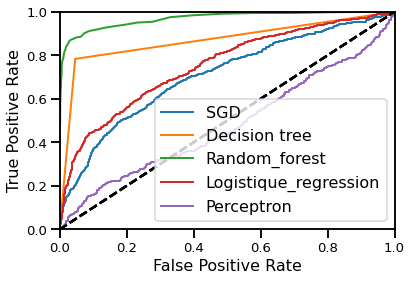

In [64]:

from sklearn.metrics import roc_curve
from sklearn import metrics

def plot_roc_curve_decis(model, name):
    pred = cross_val_predict(model, X_train, Y_train, cv=3, method="decision_function")
    fpr, tpr, thresholds = roc_curve(Y_train, pred)
    m=metrics.auc(fpr, tpr)
    print('AUC - ' +name, m)
    plt.plot(fpr, tpr, linewidth=2, label=name)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

def plot_roc_curve_proba(model, name):
    pred = cross_val_predict(model, X_train, Y_train, cv=3, method="predict_proba")
    fpr, tpr, thresholds = roc_curve(Y_train, pred[:,1])
    m=metrics.auc(fpr, tpr)
    print('AUC - ' +name, m)
    plt.plot(fpr, tpr, linewidth=2, label=name)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

# La courbe ROC est un autre moyen d'évaluer un classifieur binaire. Elle confronte le _taux de vrai positif_ (_TPR_ ou _recall_) au _taux de faux positif_

plot_roc_curve_decis(sgd_gs, "SGD")
plot_roc_curve_proba(dtrs, "Decision tree")
plot_roc_curve_proba(rf_rs, "Random_forest")
plot_roc_curve_decis(lr, "Logistique_regression")
plot_roc_curve_decis(perceptron_gs, "Perceptron")

plt.legend(loc="lower right", fontsize=16)
plt.show()

### Choisir le meilleur model a adopté

|  Variable  | Modèles    | Hyperparametre | Perf         | Capacité de calcule      | Explication                     |
|-----------|---------------------|----------------------|-------------------|--------------------|-------------------------|
|   |   |  | |  |
|   |  |    | |        |
|   | |   | |  |
|   |   |   ||  |
|   |   |    | |  |   |

|  Modèles  |Arbre de décision    |Régression logistique |Perceptron         | Random Forest      | SGD                     |
|-----------|---------------------|----------------------|-------------------|--------------------|-------------------------|
|  Accuracy | 0.9807256235827665  | 0.8537414965986394   |0.8390022675736961 | 0.9648526077097506 |0.7517006802721088
|  Precision| 0.9770992366412213 | 0.7241379310344828   |0.3065326633165829 | 1.0                |0.3121951219512195
|  Recall   | 0.9014084507042254 | 0.14788732394366197  |0.4295774647887324| 0.852112676056338  |0.4507042253521127
|  F1 Score | 0.9377289377289377  | 0.24561403508771928  |0.35777126099706746  | 0.9201520912547528 |0.3688760806916426
|  AUC      | 0.8774178565764926  | 0.7542613729166803   |0.5324098354132132 | 0.9569235913667219 | 0.6922136213072507  |

Après avoir examiné les scores des différents modèles en fonction de deux critères, à savoir la performance et l'interprétabilité, nous avons choisi l'arbre de décision comme modèle préféré. Cette décision a été motivée par le fait que l'arbre de décision est à la fois très performant et facilement interprétable. En effet, l'arbre de décision est un modèle d'apprentissage supervisé qui divise de manière récursive l'espace des caractéristiques en sous-espaces en fonction de leurs valeurs, jusqu'à ce que chaque sous-espace soit associé à une décision ou à une classe spécifique. Chaque nœud de l'arbre représente une décision basée sur une caractéristique, et chaque feuille représente une classe. En conséquence, il est relativement simple de comprendre comment l'arbre de décision prend des décisions en examinant sa structure

Nous allons donc dessiner l'arbre de decision pour comprendre les features les plus importants lors de la classification

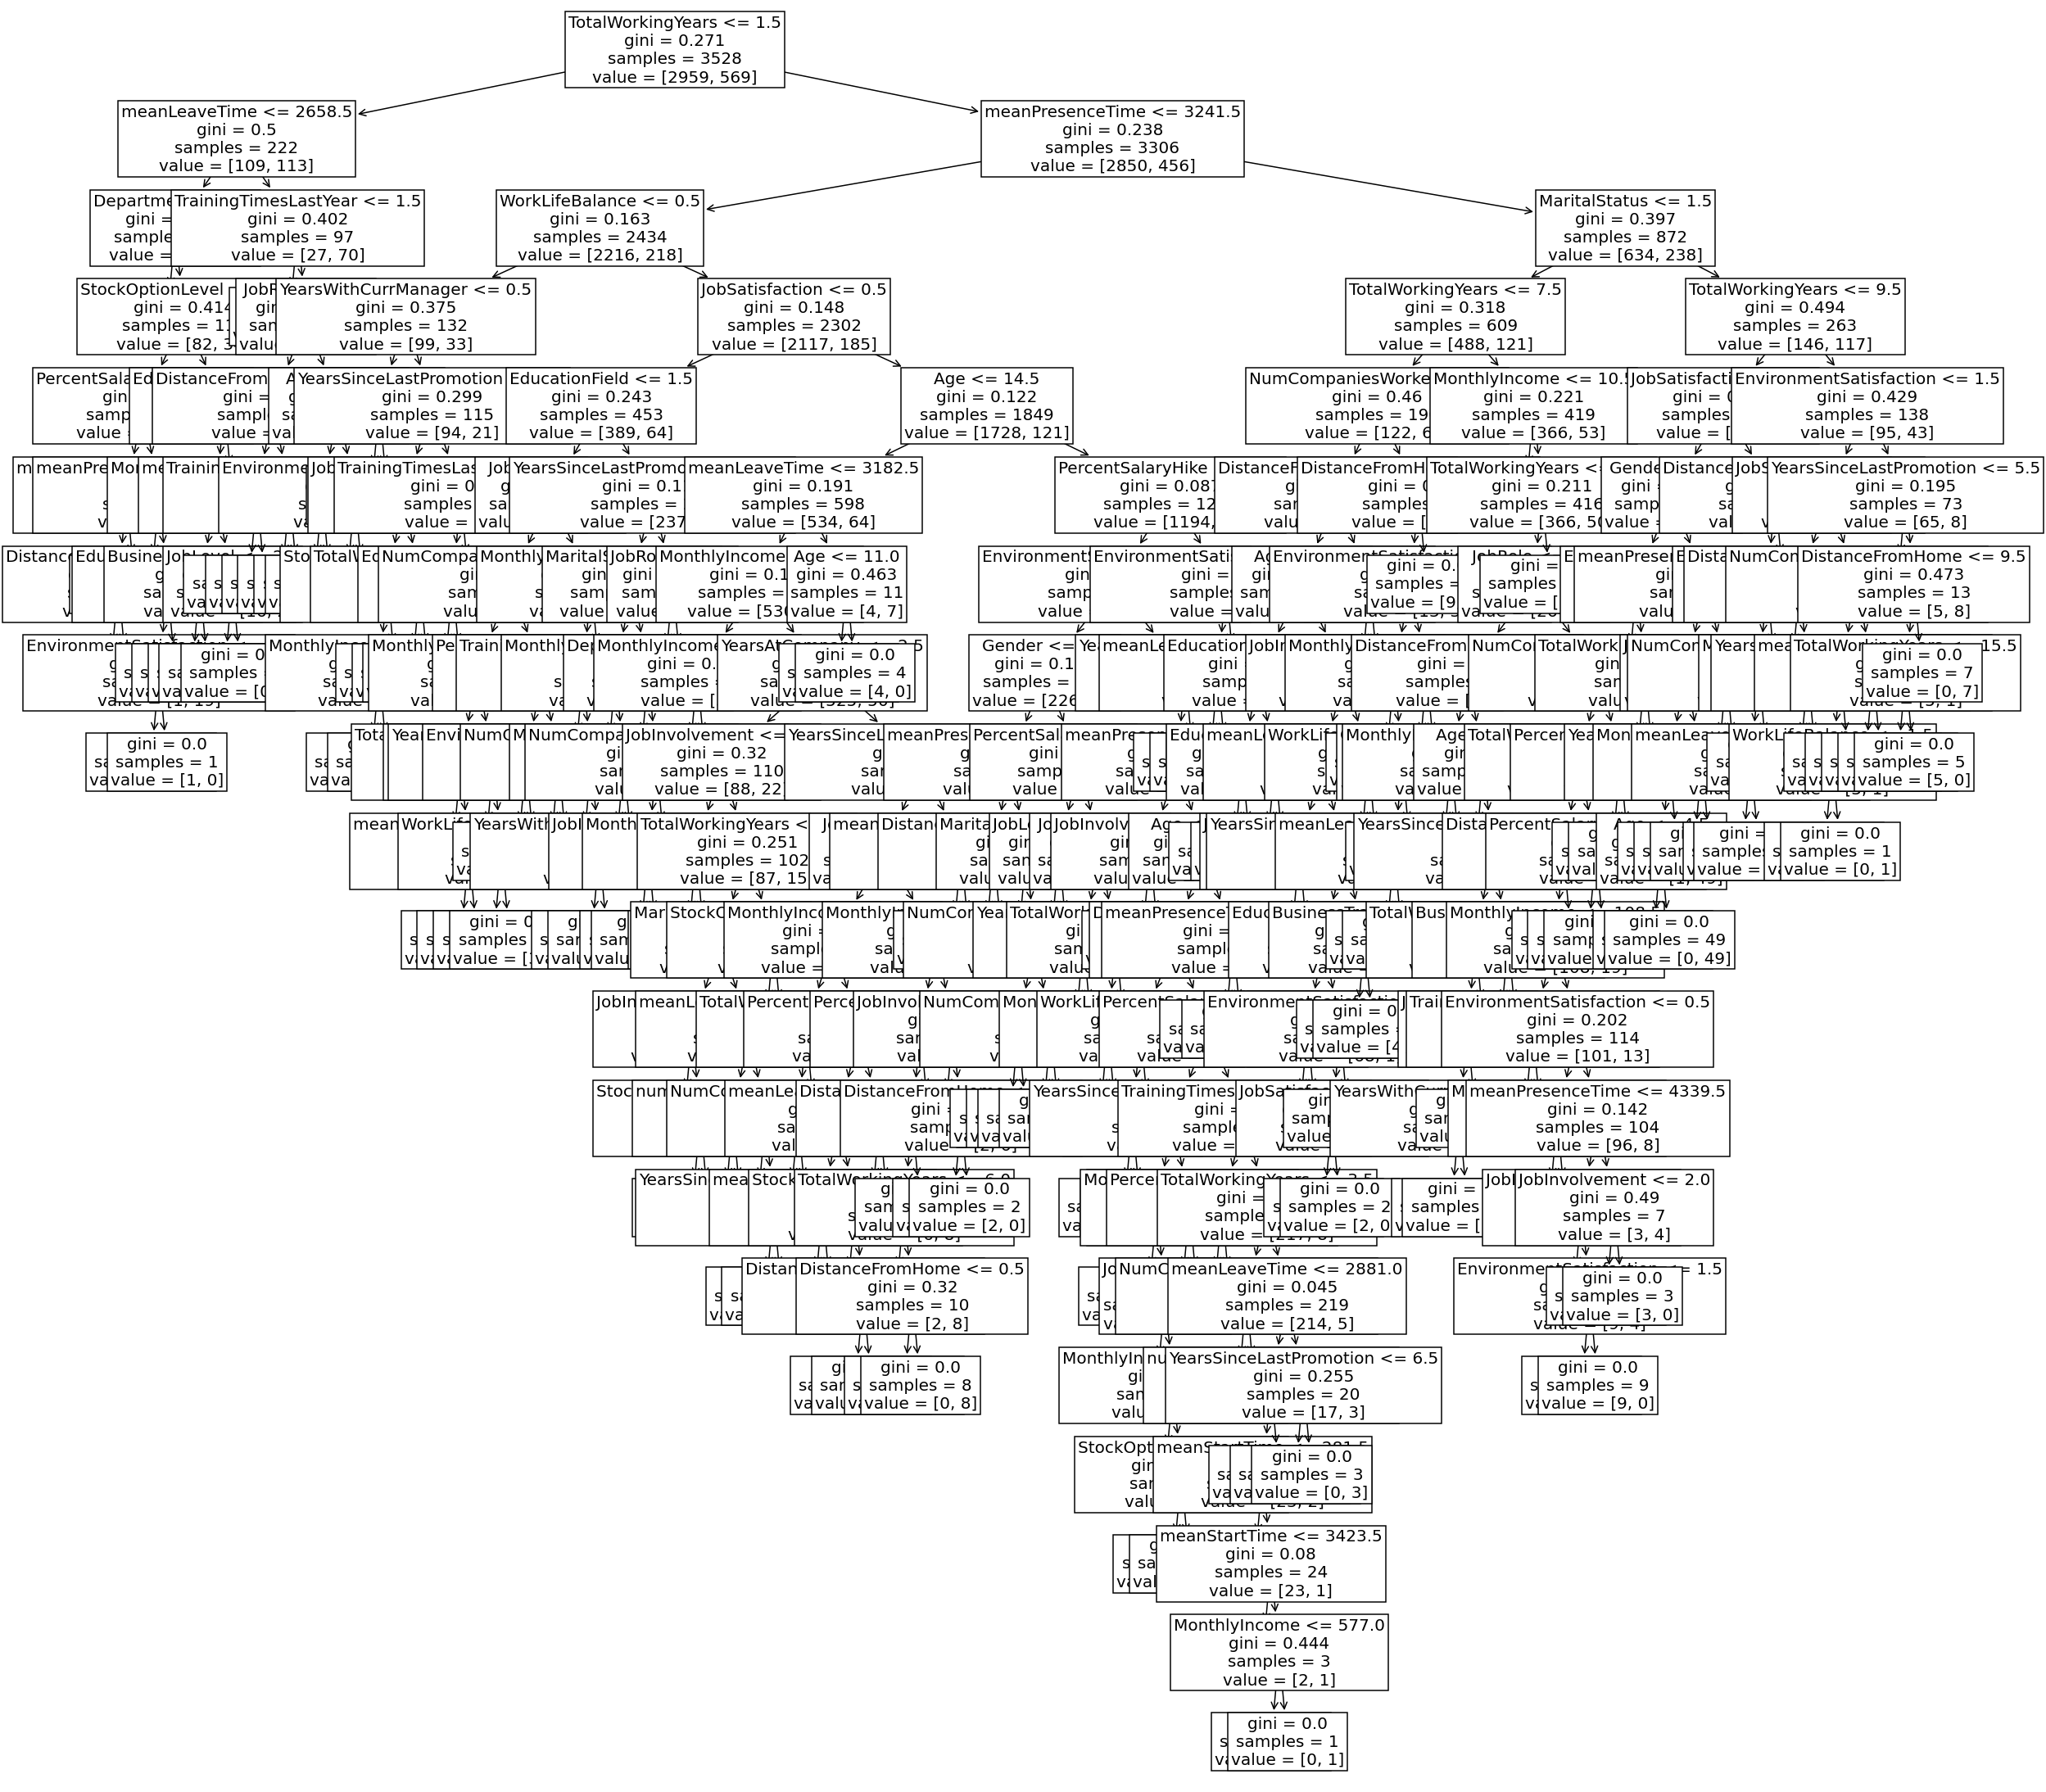

In [65]:
from sklearn import tree
plt.figure(figsize=(40,40))

tree.plot_tree(dtrs, feature_names= X_test.columns,fontsize=20)
tree.export_graphviz(dt,
                     out_file="tree.dot",
                     feature_names = X_test.columns,
                     class_names="Attrition",
                     filled = True)

TotalWorkingYears: 0.12640672193296312
MonthlyIncome: 0.08121742801405281
meanPresenceTime: 0.07334232572408536
DistanceFromHome: 0.06872145473329412
NumCompaniesWorked: 0.06424272930811756
PercentSalaryHike: 0.05406354398328191
meanLeaveTime: 0.04897648379857071
EnvironmentSatisfaction: 0.045659217470618
Age: 0.04463891945489551
JobRole: 0.0382154917469613
MaritalStatus: 0.03403787293417105
YearsSinceLastPromotion: 0.032948335312089155
JobSatisfaction: 0.032542138630912806
EducationField: 0.03179455500756526
JobInvolvement: 0.031333026048456725
TrainingTimesLastYear: 0.029515091480836416
StockOptionLevel: 0.025262273336315543
WorkLifeBalance: 0.021226597777880604
BusinessTravel: 0.019759172034958878
Education: 0.019720242256355304
JobLevel: 0.018456465297920655
Gender: 0.013405049381129297
YearsWithCurrManager: 0.013365768628935265
Department: 0.013324135663006146
YearsAtCompany: 0.012772329344540527
numberOfAbsenceDay: 0.0025940030920986587
meanStartTime: 0.0024586276059871547
Perfor

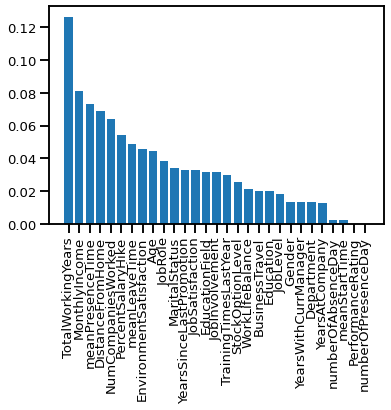

In [66]:
importances = dtrs.feature_importances_

# Sort the feature importances in descending order
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]

# Print the feature importances
for i in range(len(sorted_importances)):
    print(f"{X_test.columns[sorted_indices[i]]}: {sorted_importances[i]}")

# Plot the feature importances
plt.bar(X_test.columns[sorted_indices], sorted_importances)
plt.xticks(rotation=90)
plt.show()